In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

import pandas as pd
import numpy as np
#import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
pd.set_option("display.max_rows", 100)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option("display.max_colwidth", 100)

In [227]:
# USER DEFINED FUNCTIONS

## Function to print a header for cell outputs
def print_header(analysis, len_header=100):
    return print('\n'+'-'*int((len_header-len(analysis))/2),analysis,'-'*(int((len_header-len(analysis))/2)-1))

## BETTER WAY TO PRINT TIME INTERVALS
def print_elapsed(elapsed):
    if elapsed < 60:
        magnitude = 'seconds'
        print(elapsed, 
            magnitude)
    elif elapsed <= 60**2:
        magnitude = 'minutes'
        print(elapsed//60, 
            magnitude if elapsed//60 != 1 else magnitude[:-1], ',', 
            elapsed%60, 
            'seconds' if elapsed%60 != 1 else 'second')
    elif elapsed < 60**2*24:
        magnitude = 'hours'
        print(elapsed//(60**2),
            magnitude if elapsed//(60**2) != 1 else magnitude[:-1], ',', 
            (elapsed%(60**2))//60, 
            'minutes,' if (elapsed%(60**2))//60 != 1 else 'minute,',
            (elapsed%(60**2))%60, 
            'seconds' if (elapsed%(60**2))%60 != 1 else 'second')
    elif elapsed < 60**2*24*7:
        magnitude = 'days'
        print(elapsed//(60**2*24), 
            magnitude if elapsed//(60**2*24) != 1 else magnitude[:-1], ',',
            (elapsed%(60**2*24))//(60**2), 
            'hours,' if (elapsed%(60**2*24))//(60**2) != 1 else 'hour,',
            ((elapsed%(60**2*24))%(60**2))//60, 
            'minutes,' if ((elapsed%(60**2*24))%(60**2))//60 != 1 else 'minute,',
            ((elapsed%(60**2*24))%(60**2))%60, 
            'seconds' if ((elapsed%(60**2*24))%(60**2))%60 != 1 else 'second')
    else: 
        magnitude = 'weeks'
        print(elapsed//(60**2*24*7), 
            magnitude if elapsed//(60**2*24*7) != 1 else magnitude[:-1], ',',
            (elapsed%(60**2*24*7))//(60**2*24), 
            'days,' if (elapsed%(60**2*24*7))//(60**2*24) != 1 else 'day,',
            ((elapsed%(60**2*24*7))%(60**2*24))//(60**2), 
            'hours,' if ((elapsed%(60**2*24*7))%(60**2*24))//(60**2) != 1 else 'hour,',
            (((elapsed%(60**2*24*7))%(60**2*24))%(60**2))//60, 
            'minutes,' if (((elapsed%(60**2*24*7))%(60**2*24))%(60**2))//60 != 1 else 'minute,',
            ((((elapsed%(60**2*24*7))%(60**2*24))%(60**2))%60)%60, 
            'seconds' if ((((elapsed%(60**2*24*7))%(60**2*24))%(60**2))%60)%60 != 1 else 'second')


## RELATIVE BOXPLOT to compare a categorical var (main_var) and a numerical variable (comparison_var)
def relative_boxplot(df, main_var, comparison_var, threshold=np.inf):

    df_temp = df[[main_var, comparison_var]].copy()
    
    df_temp_pvt = df_temp[df_temp[comparison_var]<=threshold].pivot(values=comparison_var, columns=main_var)
    new_cols = df_temp_pvt.columns.tolist()
    df_temp_pvt['FULL DF'] = df_temp_pvt.fillna(0).sum(axis=1, numeric_only=True)
    df_temp_pvt = df_temp_pvt[['FULL DF']+new_cols]

    df_temp_pvt.plot(kind='box', figsize=(8,3))
    plt.title(f'{comparison_var} per {main_var} boxplot distribution\n({comparison_var}<={threshold})')
    plt.ylabel(comparison_var)
    
    if int(df_temp[comparison_var].max()) <= 1:
        pass
    elif (int(df_temp.describe().loc['75%',comparison_var])+int(df_temp.describe().loc['std',comparison_var]*1)) <= 99:
        plt.ylim([0,
                #round((int(df_temp.describe().loc['75%',comparison_var])+int(df_temp.describe().loc['std',comparison_var]*2)),-1)
                round((int(df_temp.describe().loc['75%',comparison_var])+int(df_temp.describe().loc['std',comparison_var]*1)),-1)
                ])
    else:
        plt.ylim([0,
                round((int(df_temp.describe().loc['75%',comparison_var])+int(df_temp.describe().loc['std',comparison_var]*1)),-2)
                ])


# Distribution/Bar plot for nominal categorical variables (could be applied to other categorical variables as well).
def categ_var_analysis(df, categ_var):
    df_temp_grp = df.reset_index().rename(columns={'index':'offer_id'})[['offer_id', categ_var]].groupby(categ_var).agg(num_offers=('offer_id','count')).reset_index()

    x = df_temp_grp[categ_var]
    y = df_temp_grp['num_offers']

    my_cmap = plt.get_cmap("Paired")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    
    fig, ax = plt.subplots(figsize=(8,4))
    vbars = ax.bar(x, y, width=0.5, color=my_cmap(rescale(y)))
    ax.bar_label(vbars, fontsize=8, fmt='{:,.0f}')
    plt.xticks(ticks=range(0,len(df_temp_grp[categ_var].unique())))
    plt.title(f'Number of Offers per {categ_var.upper()}')
    plt.show()



## RELATIVE SUBPLOTS to compare a numerical var (x) and our sales vars (sales_rate and sold_quantity)
def relative_sales_sublots(df, x, max_x='NA', min_x=0, max_y='NA', min_y=0):
    
    df_temp = df[[x,'sales_rate','sold_quantity_fixed']].copy()

    if isinstance(df[x][0], float):
        df_temp[x] = df_temp[x].apply(lambda var: np.ceil(var))

    elif pd.api.types.is_numeric_dtype(df[x].dtype):
        pass

    else:
        raise ValueError('x is not a numeric variable')

    df_temp_grp = df_temp.groupby(x).agg(num_offers=(x,'count'),
                                         avg_sales_rate=('sales_rate','mean'),
                                         avg_sold_quantity=('sold_quantity_fixed','mean')
                                         ).fillna(0).reset_index()
    
    df_temp_grp['avg_sold_quantity'] = df_temp_grp['avg_sold_quantity'].round(1)
    df_temp_grp['pct_offers'] = (df_temp_grp['num_offers']/len(df_temp_grp)).round(2)

    fig, ax1 = plt.subplots(figsize=(13,4))

    ax1.set_title(f'Sales Quantity & Sales/Stock Rate \n per {x.upper()}')
    vbars = ax1.bar(x=df_temp_grp[x], 
                    height=df_temp_grp.reset_index()['avg_sold_quantity'],
                    color='limegreen')
    ax1.set_xlabel(x.upper())
    ax1.set_ylabel('Average QUANTITY of Sales')
    ax1.yaxis.label.set_color('limegreen')
    ax1.tick_params(axis='y', colors='limegreen')
    if isinstance(df[x][0], int):
        ax1.bar_label(vbars, fontsize=9, color='green')
    elif isinstance(df[x][0], float):
        pass
    
    if max_x == 'NA':
        pass
    else: 
        ax1.set_xlim(min_x,max_x)
    
    if max_y == 'NA':
        pass
    else: 
        ax1.set_ylim(min_y,max_y)    

    ax2 = ax1.twinx()

    ax2.plot(df_temp_grp[x], df_temp_grp['avg_sales_rate'],c='#1f77b4', linewidth=0.8, marker='.')# '--', marker='.', c='#1f77b4')
    ax2.set_yticks([a/10 if a!=0 else 0 for a in range(0,11)])
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Average Sales RATE (SALES/STOCK)')
    ax2.yaxis.label.set_color('#1f77b4')
    ax2.tick_params(axis='y', colors='#1f77b4')

    plt.show()

# SIMPLE BOXPLOT FOR NUMERICAL VAR ANALYSIS
def simple_boxplot(df, var):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title(f'{var.upper()} BoxPlot')
    ax.boxplot(df[var])
    if int(df[var].max()) <= 1:
        pass
    elif (int(df.describe().loc['75%',var])+int(df.describe().loc['std',var]*1)) <= 99:
        ax.set_ylim(0, round((int(df.describe().loc['75%',var])+int(df.describe().loc['std',var]*1)),-1))
    else:
        #ax.set_ylim(0, round((int(df.describe().loc['75%',var])+int(df.describe().loc['std',var]*1)),-2))
        ax.set_ylim(0, int(df.describe().loc['50%',var]*4))
    ax.set_xticks(ticks=[1], labels=['full df'])
    ax.set_ylabel(f'{var} value')


# WELCOMING THE DATA

## Importing the dataset (ofertas_relampago.csv)

In [3]:
# Let's store an original version of the dataset
df_orig = pd.read_csv('ofertas_relampago.csv')

df = df_orig.copy()
original_cols = df.columns.to_list()
df.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


First of all, let's remove the duplicate obervations (if there are any)

In [4]:
print(f'Number of rows/observations before drop_duplicates:\t\t{len(df):,}')
print(f'Number of rows/observations after drop_duplicates:\t\t{len(df.drop_duplicates()):,}')
print(f'# of dropped rows/observations:\t\t\t\t\t{len(df)-len(df.drop_duplicates()):,}')

df.drop_duplicates(inplace=True)

Number of rows/observations before drop_duplicates:		48,746
Number of rows/observations after drop_duplicates:		47,820
# of dropped rows/observations:					926


## Data Types (dtypes)

In [5]:
print(f'The dataframe contains {df.shape[0]} rows (observations) and {df.shape[1]} columns (attributes) \n')
print_header('COLUMNS AND THEIR DATATYPES')
print(df.dtypes)
print('-'*100)

The dataframe contains 47820 rows (observations) and 13 columns (attributes) 


------------------------------------ COLUMNS AND THEIR DATATYPES -----------------------------------
OFFER_START_DATE              object
OFFER_START_DTTM              object
OFFER_FINISH_DTTM             object
OFFER_TYPE                    object
INVOLVED_STOCK                 int64
REMAINING_STOCK_AFTER_END      int64
SOLD_AMOUNT                  float64
SOLD_QUANTITY                float64
ORIGIN                        object
SHIPPING_PAYMENT_TYPE         object
DOM_DOMAIN_AGG1               object
VERTICAL                      object
DOMAIN_ID                     object
dtype: object
----------------------------------------------------------------------------------------------------


In [6]:
num_cols = df.select_dtypes(include='number').columns.tolist()
str_cols = df.select_dtypes(include='object').columns.tolist()
bool_cols = df.select_dtypes(include='bool').columns.tolist()
dt_cols = df.select_dtypes(include='datetimetz').columns.tolist()

# -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 
print_header(f'NUMERIC COLUMNS: {len(num_cols)}')
if len(num_cols) > 0:
    for col in num_cols:
        print(f'- {col}: {df[col].dtype}')
    print('(num_cols list created with all numeric type columns\' names)')
else:
    print('- (No numeric columns)')

# -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 

print_header(f'STRING COLUMNS: {len(str_cols)}')
if len(str_cols) > 0:
    for col in str_cols:
        print(f'- {col}: {df[col].dtype}')
    print('(str_cols list created with all string/object type columns\' names)')
else:
    print('- (No string columns)')

# -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 

print_header(f'DATETIME COLUMNS: {len(dt_cols)}')
if len(dt_cols) > 0:
    for col in dt_cols:
        print(f'- {col}: {df[col].dtype}')
    print('(dt_cols list created with all datetime type columns\' names)')
else:
    print('- (No datetime columns)')

# -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 

print_header(f'BOOLEAN COLUMNS: {len(bool_cols)}')
if len(bool_cols) > 0:
    for col in bool_cols:
        print(f'- {col}: {df[col].dtype}')
    print('(bool_cols list created with all boolean type columns\' names)')
else:
    print('- (No boolean columns)')

print('-'*100) 
# -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 


----------------------------------------- NUMERIC COLUMNS: 4 ----------------------------------------
- INVOLVED_STOCK: int64
- REMAINING_STOCK_AFTER_END: int64
- SOLD_AMOUNT: float64
- SOLD_QUANTITY: float64
(num_cols list created with all numeric type columns' names)

----------------------------------------- STRING COLUMNS: 9 ----------------------------------------
- OFFER_START_DATE: object
- OFFER_START_DTTM: object
- OFFER_FINISH_DTTM: object
- OFFER_TYPE: object
- ORIGIN: object
- SHIPPING_PAYMENT_TYPE: object
- DOM_DOMAIN_AGG1: object
- VERTICAL: object
- DOMAIN_ID: object
(str_cols list created with all string/object type columns' names)

---------------------------------------- DATETIME COLUMNS: 0 ---------------------------------------
- (No datetime columns)

----------------------------------------- BOOLEAN COLUMNS: 0 ----------------------------------------
- (No boolean columns)
-------------------------------------------------------------------------------------------

## Data Quality & Missing Values

In [7]:
# DESCRIBING NUMERIC DATA
print_header('NUMERIC VARIABLES DESCRIPTION')
print(df.describe())


# MISSING DATA
print(f'total number of rows: {len(df):,}')
df_null_analysis = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'col_name', 0:'null_rows'})
df_null_analysis['null_rows_pct'] = (df_null_analysis['null_rows']/len(df)*100).round(1).astype(str)+'%'

print_header('NULL VALUES')
print(df_null_analysis)


----------------------------------- NUMERIC VARIABLES DESCRIPTION ----------------------------------
       INVOLVED_STOCK  REMAINING_STOCK_AFTER_END   SOLD_AMOUNT  SOLD_QUANTITY
count    47820.000000               47820.000000  24548.000000   24548.000000
mean        35.153095                  30.641029     51.177417      10.861455
std        208.339376                 197.270692    175.319125      45.502831
min          1.000000                -192.000000      0.280000       1.000000
25%          5.000000                   4.000000      5.730000       1.000000
50%         10.000000                   8.000000     12.415000       3.000000
75%         15.000000                  15.000000     30.882500       6.000000
max       9000.000000                8635.000000   4836.570000    1646.000000
total number of rows: 47,820

-------------------------------------------- NULL VALUES -------------------------------------------
                     col_name  null_rows null_rows_pct
0         

#### What can we extract from this summary?

**DTYPES**
- When importing the data, we can see that there are string columns that need to be converted to datetime format for further comparison and feature engineering.
- This variables are: `OFFER_START_DATE`, `OFFER_START_DTTM`, and `OFFER_FINISH_DTTM`

**DATA QUALITY**
- `INVOLVE_STOCK` seems to make logical sense, that is, it represents the number of available stock for an offer and it has a minimum value of 1 (there is no offer without stock).
- `REMAINING_STOCK_AFTER_END` which is the result of `INVOLVED_STOCK - SOLD_QUANTITY`, has a minimum value of `-192`, which I believe needs to be fixed. Sales should not exceed the stock available.
- `SOLD_QUANTITY`, as mentioned in the previous point, is used to calculate `REMAINING_STOCK_AFTER_END`, and in some cases `SOLD_QUANTITY > INVOLVE_STOCK`. We will fix it and use it to calculate a new `REMAINING_STOCK_AFTER_END`.
- `SOLD_AMOUNT`, which is a monetary representation of the sales, will need to be fixed as well once we have the fixed `SOLD_QUANTITY` and calculated unit price: `(SOLD_AMOUNT/SOLD_QUANTITY) * fixed_SOLD_QUANTITY`

**NULL VALUES**
- We have in this dataframe 3 columns with missing values.
- `SOLD_AMOUNT` and `SOLD_QUANTITY` missing values imply no sales at all for that observation. We will fill those missing values with the int `0` (zero).
- `ORIGIN` is a string variable that has close to 77% of the observations with missing values, and the rest with a the same value of `'A'`. We will analyse if there is any particularity for `'A'` observations, otherwise we will drop the column.

With that being said, we can start cleaning the data.

## CLEANING THE DATA

### DATA TYPES

As was mentioned before, we can see that there are some date and datetime columns that are currently in string (object) type.

To be able to make date and time comparissons we will need to convert them to datetime type.
- `OFFER_START_DATE` converted will be called `OFFER_START_DATE_dt`
- `OFFER_START_DTTM` converted will be called `OFFER_START_DTTM_dt`
- `OFFER_FINISH_DTTM` converted will be called `OFFER_FINISH_DTTM_dt`

In [8]:
df['OFFER_START_DATE_dt'] = pd.to_datetime(df['OFFER_START_DATE'])
df['OFFER_FINISH_DTTM_dt'] = pd.to_datetime(df['OFFER_FINISH_DTTM'])
df['OFFER_START_DTTM_dt'] = pd.to_datetime(df['OFFER_START_DTTM'])

cols_df = ['OFFER_START_DATE', 'OFFER_START_DATE_dt',
           'OFFER_START_DTTM', 'OFFER_START_DTTM_dt',
           'OFFER_FINISH_DTTM', 'OFFER_FINISH_DTTM_dt'
           ]

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
print_header('OFFER_START_DATE description')
print(df[cols_df].describe())

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
print_header('dtypes VALIDATION')

print(
    df[['OFFER_START_DATE', 'OFFER_START_DATE_dt',
        'OFFER_START_DTTM', 'OFFER_START_DTTM_dt',
        'OFFER_FINISH_DTTM', 'OFFER_FINISH_DTTM_dt'
        ]].dtypes
)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
print_header('CONTENT VALIDATION')
df[cols_df].head(2)


------------------------------------ OFFER_START_DATE description -----------------------------------
                 OFFER_START_DATE_dt
count                          47820
mean   2021-07-05 12:12:29.811793920
min              2021-06-01 00:00:00
25%              2021-06-22 00:00:00
50%              2021-07-07 00:00:00
75%              2021-07-21 00:00:00
max              2021-07-31 00:00:00

----------------------------------------- dtypes VALIDATION ----------------------------------------
OFFER_START_DATE                     object
OFFER_START_DATE_dt          datetime64[ns]
OFFER_START_DTTM                     object
OFFER_START_DTTM_dt     datetime64[ns, UTC]
OFFER_FINISH_DTTM                    object
OFFER_FINISH_DTTM_dt    datetime64[ns, UTC]
dtype: object

----------------------------------------- CONTENT VALIDATION ----------------------------------------


,OFFER_START_DATE,OFFER_START_DATE_dt,OFFER_START_DTTM,OFFER_START_DTTM_dt,OFFER_FINISH_DTTM,OFFER_FINISH_DTTM_dt
0,2021-06-22,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,2021-06-22 23:02:43+00:00
1,2021-06-22,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,2021-06-22 19:00:02+00:00


#### DATA QUALITY
Fixing `SOLD_QUANTITY` and `SOLD_AMOUNT`

In [9]:
'''
We will fill na for the columns that we can interpret, SOLD_AMOUNT and SOLD_QUANTITY, 
which we can assume that: if missing, then 0.
'''
df['SOLD_AMOUNT'].fillna(0,inplace=True)
df['SOLD_QUANTITY'].fillna(0,inplace=True)


# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
'''
Now, let's fix the data, considering that there are some records that show more sales than there is stock.
We will create three new features:
- 'sold_quantity_fixed' as a fixed version of 'SOLD_QUANTITY'
- 'remaining_stock_after_end_fixed' as a fixed version of 'REMAINING_STOCK_AFTER_END'
- 'sold_amount_fixed' as a fixed version of 'SOLD_AMOUNT'
'''

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 'sold_quantity_fixed'
'''
We will start by fixing 'SOLD_QUANTITY'. If 'SOLD_QUANTITY' > 'INVOLVED_STOCK' then 'INVOLVED_STOCK' else 'SOLD_QUANTITY'.
We shall start with creating a function to then apply it to our df and create the fixed column
'''

def sold_qty_fixer(stock,sales):
    if sales > stock:
        return stock
    else:
        return sales

df['sold_quantity_fixed'] = (df.apply(lambda x: sold_qty_fixer(x.INVOLVED_STOCK, x.SOLD_QUANTITY), axis=1)).astype(int)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 'remaining_stock_after_end_fixed'
''' 
Now we can fix the 'REMAINING_STOCK_AFTER_END' column, by subtracting the new 'sold_quantity_fixed' from the 'INVOLVED_STOCK'
'''

df['remaining_stock_after_end_fixed'] = (df['INVOLVED_STOCK']-df['sold_quantity_fixed']).astype(int)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 'sold_amount_fixed'
'''
Finally, we will fix the 'SOLD_AMOUNT' column by dividing it by the previous/wrong 'SOLD_QUANTITY' 
and multiplying this unit price by the new/fixed 'sold_quantity_fixed'
(Here I am assuming that the SOLD_AMOUNT reflects the SOLD_QUANTITY times unit price, which I cannot validate with the given data)
'''
df['unit_price'] = (df['SOLD_AMOUNT']/df['SOLD_QUANTITY']).fillna(0)
df['sold_amount_fixed'] = df['unit_price']*df['sold_quantity_fixed']
df['sold_amount_fixed'].fillna(0, inplace=True)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
'''
For validation purposes, we will now print the data and make sure that the changes were correcly applied.
'''

cols_df = ['INVOLVED_STOCK', 
           'SOLD_QUANTITY', 'sold_quantity_fixed',
           'SOLD_AMOUNT', 'sold_amount_fixed',
           'REMAINING_STOCK_AFTER_END', 'remaining_stock_after_end_fixed',
           'unit_price'
           ]

print_header('VALIDATION: Fixed variables')
df[cols_df].head()


------------------------------------ VALIDATION: Fixed variables -----------------------------------


,INVOLVED_STOCK,SOLD_QUANTITY,sold_quantity_fixed,SOLD_AMOUNT,sold_amount_fixed,REMAINING_STOCK_AFTER_END,remaining_stock_after_end_fixed,unit_price
0,4,6.0,4,4.72,3.146667,-2,0,0.786667
1,5,0.0,0,0.00,0.000000,5,5,0.000000
2,15,3.0,3,10.73,10.730000,12,12,3.576667
3,15,2.0,2,7.03,7.030000,13,13,3.515000
4,15,15.0,15,39.65,39.650000,0,0,2.643333


Now that we have the sales and stock data making sense, we can create a feature that would represent 'success'.
This will help us:
- capture irrelevance in the data.
- understande the relationship between each variable and our definition of 'success'.
- find patterns and opportunitites in our analyses.

In [10]:
# FEATURE ENGINEERING ('SUCCESS' feature)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# sales_rate: Percentage of the INVOLVED_STOCK that was sold (INVOLVED_STOCK/sold_quantity_fixed).
'''
Observing the data, it would be interesting to understand the relationship between our features (independent variables) and some
rate of success (dependent variable).
In this case we could create a new column containing the rate of SALES/STOCK. We will have a percentage of the INVOLVED_STOCK
that was actually sold (SOLD_QUANTITY).
Considering that we have cleaned the data, we can now execute this logic and create this feature of interest quite simply.
'''

df['sales_rate'] = df['sold_quantity_fixed']/df['INVOLVED_STOCK']

cols_df = ['INVOLVED_STOCK', 
           'sold_quantity_fixed',
           'sales_rate', # <------------
           'sold_amount_fixed',
           'remaining_stock_after_end_fixed',
           'unit_price'
           ]

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
'''
Now, we are ready to understand the relationship between the different variables available and our definition of 'success' ('sales_rate').

ALERT! We must keep in mind that the percentage of sales could be, and probably is, biased by the duration of the offer,
that is, offers that stay active for longer have more chances of materializing into more sales than those that 
stay active for shorter periods of time.
With that being said, we will start by observing the relationship between offer duration and sales_rate.
'''

print_header("Definition of 'SUCCESS' feature validation")
df[cols_df+['sales_rate']].head()


----------------------------- Definition of 'SUCCESS' feature validation ----------------------------


,INVOLVED_STOCK,sold_quantity_fixed,sales_rate,sold_amount_fixed,remaining_stock_after_end_fixed,unit_price,sales_rate
0,4,4,1.000000,3.146667,0,0.786667,1.000000
1,5,0,0.000000,0.000000,5,0.000000,0.000000
2,15,3,0.200000,10.730000,12,3.576667,0.200000
3,15,2,0.133333,7.030000,13,3.515000,0.133333
4,15,15,1.000000,39.650000,0,2.643333,1.000000


### MISSING VALUES
We have already filled the missing values for the `SOLD_QUANTITY` and `SOLD_AMOUNT`.

With the creation of the `sales_rate` and the fixed `sold_quantity_fixed` features we can evaluate if the `ORIGIN` is relevant at all for our analyses.

In [11]:
# We will create a copy of the df with the columns we are interested in and fill na temporarily with an arbitrary value (string 'NA')
df_origin_temp = df[['ORIGIN','INVOLVED_STOCK','sales_rate','sold_quantity_fixed', 'unit_price']].copy()
df_origin_temp['ORIGIN'].fillna('NA', inplace=True)

print_header('WHOLE DATASET')
print(df_origin_temp.describe())

print_header("ORIGIN='A' DATASET")
print(df_origin_temp[df_origin_temp['ORIGIN']=='A'].describe())

print_header("ORIGIN='NA' DATASET")
print(df_origin_temp[df_origin_temp['ORIGIN']=='NA'].describe())


------------------------------------------- WHOLE DATASET ------------------------------------------
       INVOLVED_STOCK    sales_rate  sold_quantity_fixed    unit_price
count    47820.000000  47820.000000         47820.000000  47820.000000
mean        35.153095      0.200862             5.354078      4.508363
std        208.339376      0.307361            31.564981     16.376601
min          1.000000      0.000000             0.000000      0.000000
25%          5.000000      0.000000             0.000000      0.000000
50%         10.000000      0.022222             1.000000      0.840000
75%         15.000000      0.266667             3.000000      4.121806
max       9000.000000      1.000000          1646.000000    639.070000

----------------------------------------- ORIGIN='A' DATASET ----------------------------------------
       INVOLVED_STOCK    sales_rate  sold_quantity_fixed    unit_price
count    10845.000000  10845.000000         10845.000000  10845.000000
mean       121

In [12]:
print_header("SALES, STOCK, PRICE per ORIGIN")
df_origin_temp.groupby('ORIGIN').agg(num_offers=('ORIGIN','count'),
                                     # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
                                     avg_stock=('INVOLVED_STOCK', 'mean'),
                                     min_stock=('INVOLVED_STOCK', 'min'),
                                     max_stock=('INVOLVED_STOCK', 'max'),
                                     # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
                                     avg_unit_price=('unit_price', 'mean'),
                                     min_unit_price=('unit_price', 'min'),
                                     max_unit_price=('unit_price', 'max'),
                                     # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
                                     avg_sales_rate=('sales_rate','mean'),
                                     avg_sold_qty=('sold_quantity_fixed','mean')
                                     # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
                                     ).round(2)


----------------------------------- SALES, STOCK, PRICE per ORIGIN ----------------------------------


,num_offers,avg_stock,min_stock,max_stock,avg_unit_price,min_unit_price,max_unit_price,avg_sales_rate,avg_sold_qty
ORIGIN,,,,,,,,,
A,10845,121.56,1,9000,8.28,0.0,639.07,0.14,16.62
NA,36975,9.81,5,15,3.40,0.0,496.73,0.22,2.05


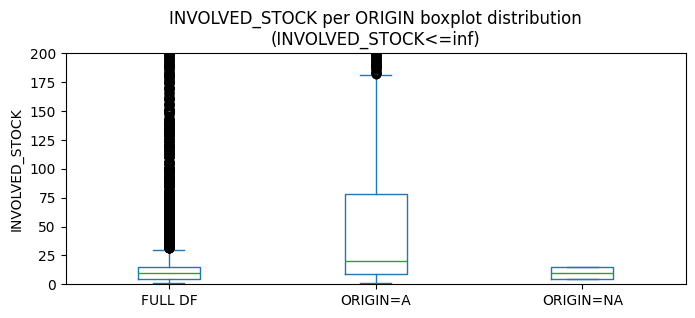

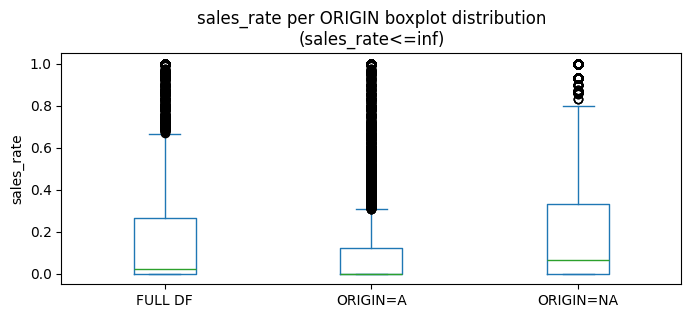

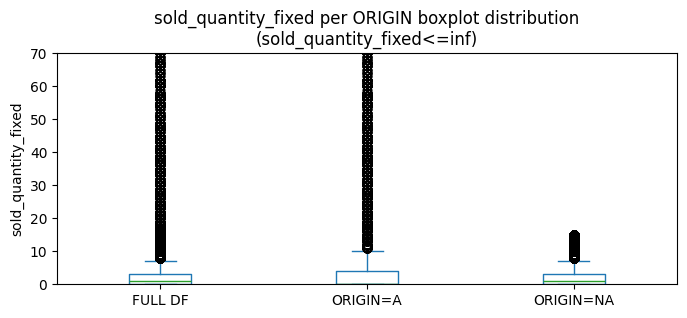

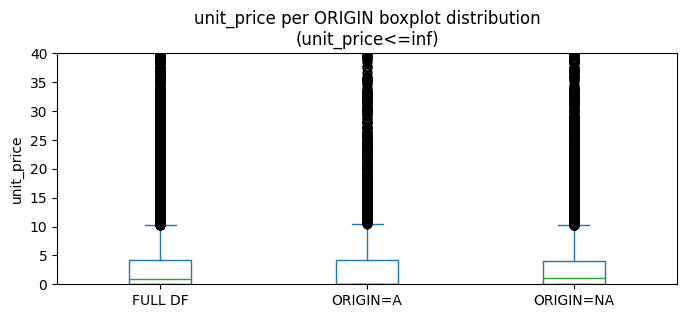

In [13]:

def relative_boxplot_ORIGIN(var, threshold=np.inf):

    df_origin_temp.head()

    df_origin_temp_pvt = df_origin_temp[df_origin_temp[var]<=threshold].pivot(values=var, columns='ORIGIN')

    df_origin_temp_pvt['FULL DF'] = df_origin_temp_pvt['A'].fillna(0)+df_origin_temp_pvt['NA'].fillna(0)
    df_origin_temp_pvt = df_origin_temp_pvt[['FULL DF', 'A', 'NA']].rename(columns={'A':'ORIGIN=A', 'NA':'ORIGIN=NA'})

    df_origin_temp_pvt.plot(kind='box', figsize=(8,3))
    plt.title(f'{var} per ORIGIN boxplot distribution\n({var}<={threshold})')
    # plt.xlabel('ORIGIN')
    plt.ylabel(var)
    if int(df_origin_temp[var].max()) <= 1:
        pass
    elif (int(df_origin_temp.describe().loc['75%',var])+int(df_origin_temp.describe().loc['std',var]*1)) <= 99:
        plt.ylim([0,
                round((int(df_origin_temp.describe().loc['75%',var])+int(df_origin_temp.describe().loc['std',var]*2)),-1)
                #round((int(df_origin_temp.describe().loc['mean',var])+int(df_origin_temp.describe().loc['std',var]*3)),-2)
                ])
    else:
        plt.ylim([0,
                round((int(df_origin_temp.describe().loc['75%',var])+int(df_origin_temp.describe().loc['std',var]*1)),-2)
                #round((int(df_origin_temp.describe().loc['mean',var])+int(df_origin_temp.describe().loc['std',var]*3)),-2)
                ])

vars = df_origin_temp.columns[1:].tolist()

for var in vars: 
    relative_boxplot_ORIGIN(var=var)


#### 'ORIGIN' COLUMN CONCLUSIONS

I have limited the y-axis to be able to properly visualize the boxplots, considering that there are many outliers in the data for most columns.

With that being said, there is considerable difference between the observations with `ORIGIN='A'` and those that previously had that information missing (now `ORIGIN='NA'`):
- `INVOLVED_STOCK`: `ORIGIN='A'` observations are much more spread out than the other observations for this variable. Offers of `ORIGIN='A'` usually have more stock.
- `sales_rate`: `ORIGIN='A'` observations less spread out than the ohter observations. Offers of `ORIGIN='A'` have lower sales_rate then the other offers (probably related to the higher number of units in stock).
- `sold_quantity_fixed` and `unit_price`: There is a slight difference but nothing too significant.

We will keep this column for analysis.

In [14]:
df['ORIGIN'].fillna('NA', inplace=True)

df.isnull().sum()

OFFER_START_DATE                   0
OFFER_START_DTTM                   0
OFFER_FINISH_DTTM                  0
OFFER_TYPE                         0
INVOLVED_STOCK                     0
REMAINING_STOCK_AFTER_END          0
SOLD_AMOUNT                        0
SOLD_QUANTITY                      0
ORIGIN                             0
SHIPPING_PAYMENT_TYPE              0
DOM_DOMAIN_AGG1                    0
VERTICAL                           0
DOMAIN_ID                          0
OFFER_START_DATE_dt                0
OFFER_FINISH_DTTM_dt               0
OFFER_START_DTTM_dt                0
sold_quantity_fixed                0
remaining_stock_after_end_fixed    0
unit_price                         0
sold_amount_fixed                  0
sales_rate                         0
dtype: int64

### WELCOMING THE DATA: First Conclusions

**DATA TYPES**
- We had to convert the date columns that were originally in string format to datetime format:
	- `OFFER_START_DATE` converted will be called `OFFER_START_DATE_dt`
	- `OFFER_START_DTTM` converted will be called `OFFER_START_DTTM_dt`
	- `OFFER_FINISH_DTTM` converted will be called `OFFER_FINISH_DTTM_dt`

**DATA QUALITY**
- We had to adjust some features to seemed to be off:
	- Sales should not exceed the stock available.
		- `SOLD_QUANTITY` fixed into `sold_quantity_fixed`
	- With sold quantity fixed we could now calculate the sold amount accordingly.
		- `SOLD_AMOUNT` fixed into `sold_amount_fixed`
	- Remaining stock after offer duration should not be negative.
		- `REMAINING_STOCK_AFTER_END` fixed into `remaining_stock_after_end_fixed`

**NULL VALUES**
- 3 columns had null values in them: 
	- `SOLD_QUANTITY`: If null, we assume that no sales were made during the 'oferta relâmpago'
	- `SOLD_AMOUNT`: If null, we assume that no sales were made during the 'oferta relâmpago'
	- `ORIGIN`: most of the observations had null values, nevertheless we could not eliminate the column, since ORIGIN='A' had different caracteristics then the observations with ORIGIN missing. We simply filled missing values with a string 'NA'.

From this point on we will use a separate dataframe (df_clean) containing only the relevant features and leaving the unadjusted ones behind.

_**ALERT: This does not mean that the df is ready and fully clean necessarily. If we come accross redundancy or strange information, we will address it during the features analyses.**_


In [15]:
cols_df_clean = [
    'OFFER_START_DATE_dt',
    'OFFER_FINISH_DTTM_dt',
    'OFFER_START_DTTM_dt',
    # -- -- -- -- -- -- -- -- -- -- -- -- 
    'INVOLVED_STOCK',
    'sold_quantity_fixed',
    'remaining_stock_after_end_fixed',
    'unit_price',
    'sold_amount_fixed',
    'sales_rate',
    # -- -- -- -- -- -- -- -- -- -- -- -- 
    'OFFER_TYPE',
    'ORIGIN',
    'SHIPPING_PAYMENT_TYPE',
    'DOM_DOMAIN_AGG1',
    'VERTICAL',
    'DOMAIN_ID'
]

df_clean = df[cols_df_clean].copy()
df_clean.head()

,OFFER_START_DATE_dt,OFFER_FINISH_DTTM_dt,OFFER_START_DTTM_dt,INVOLVED_STOCK,sold_quantity_fixed,remaining_stock_after_end_fixed,unit_price,sold_amount_fixed,sales_rate,OFFER_TYPE,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 23:02:43+00:00,2021-06-22 16:00:00+00:00,4,4,0,0.786667,3.146667,1.000000,lightning_deal,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 19:00:02+00:00,2021-06-22 13:00:00+00:00,5,0,5,0.000000,0.000000,0.000000,lightning_deal,NA,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 13:00:01+00:00,2021-06-22 07:00:00+00:00,15,3,12,3.576667,10.730000,0.200000,lightning_deal,NA,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-23 01:36:12+00:00,2021-06-22 19:00:00+00:00,15,2,13,3.515000,7.030000,0.133333,lightning_deal,NA,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 15:48:12+00:00,2021-06-22 13:00:00+00:00,15,15,0,2.643333,39.650000,1.000000,lightning_deal,NA,none,COMPUTERS,CE,MLM-HEADPHONES


# Feature Analysis

## Datetime columns and their values

### Datetime columns analysis

- We will understand now if there are any strange values in the datetime columns

- We will also understand how the data is distributed through time.

- Further on, we will engineer some features as an attempt to extract more value out of the data.

In [16]:
print('OFFER_START_DATE')
print(f"- Oldest 'Offer Start Date': {min(df_clean["OFFER_START_DTTM_dt"].dt.date)}")
print(f"- Most recent 'Offer Start Date': {max(df_clean["OFFER_START_DTTM_dt"].dt.date)}")
print('-'*100)
print('OFFER_FINISH_DTTM')
print(f"- Oldest 'Offer End Date': {min(df_clean["OFFER_FINISH_DTTM_dt"].dt.date)}")
print(f"- Most recent 'Offer End Date': {max(df_clean["OFFER_FINISH_DTTM_dt"].dt.date)}")


OFFER_START_DATE
- Oldest 'Offer Start Date': 2021-06-01
- Most recent 'Offer Start Date': 2021-07-31
----------------------------------------------------------------------------------------------------
OFFER_FINISH_DTTM
- Oldest 'Offer End Date': 2021-06-01
- Most recent 'Offer End Date': 2021-08-01


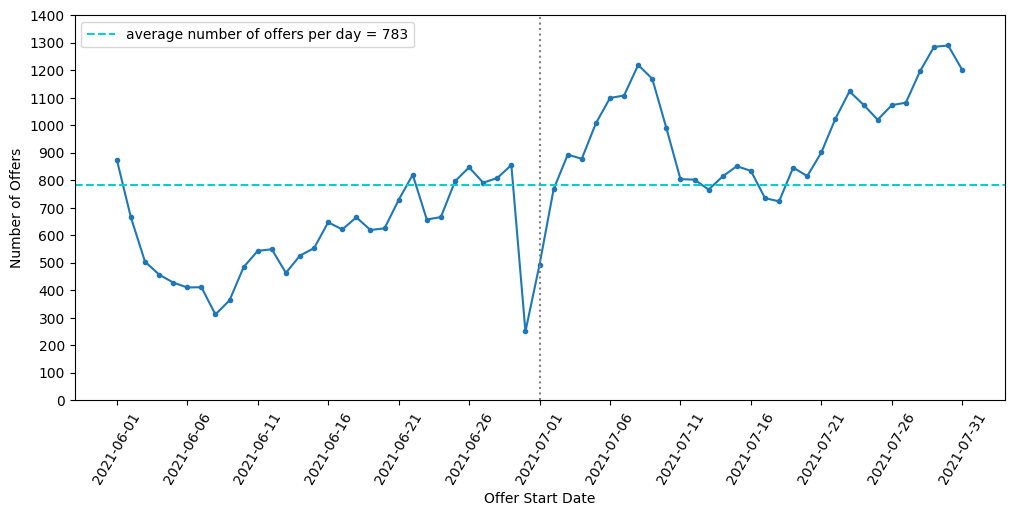

In [17]:
'''Let's plot the number of offers per offer start date to see if there is any concentration in a specific date'''
df_ts_temp = df_clean[['OFFER_START_DATE_dt']].reset_index().groupby('OFFER_START_DATE_dt').agg(num_offers=('index','count')).copy()

import datetime as dt

plt.figure(figsize=(12,5))
plt.plot(df_ts_temp, marker='.')

plt.yticks(range(0,round(max(df_ts_temp['num_offers']),-2)+200,100))
plt.ylabel('Number of Offers')
plt.axhline(np.mean(df_ts_temp['num_offers']), ls='--', c='darkturquoise', label=f'average number of offers per day = {int(np.mean(df_ts_temp['num_offers']))}')

plt.xticks([df_ts_temp.reset_index()['OFFER_START_DATE_dt'][i] for i in range(0,len(df_ts_temp),5)],rotation=60)
plt.xlabel('Offer Start Date')
plt.axvline(dt.date(2021,7,1), ls=':', c='gray')

plt.legend()

plt.show()


There is no apparent need to fix the date features.

Some interesting findings we can absorb from the line chart is that in July there were more ofertas relâmpago then June.

Now that we have pre-validated the date features, we can proceed to create new features with them and extract more information from the dataset.

### Feature Engineering (Date columns)

Let's try to find out more about these offers 'oferta relâmpago" and how long they last

#### Offer Duration
- `offer_duration`: how long was the oferta relâmpago active for (in timedelta format)
- `offer_duration_seconds`: how long was the oferta relâmpago active for (in seconds, int format)
- `offer_duration_minutes`: how long was the oferta relâmpago active for (in minutes, int format)
- `offer_duration_hours`: how long was the oferta relâmpago active for (in hours, int format)
- `offer_duration_days`: how long was the oferta relâmpago active for (in days, int format)

In [18]:
hour_test = 7.1*60*60
print(hour_test)
print(hour_test//60)
print(hour_test/60//60)

25560.0
426.0
7.0


In [19]:
df_clean['offer_duration'] = (df_clean['OFFER_FINISH_DTTM_dt']-df_clean['OFFER_START_DTTM_dt'])
df_clean['offer_duration_seconds'] = (df_clean['OFFER_FINISH_DTTM_dt']-df_clean['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)
df_clean['offer_duration_minutes'] = (df_clean['OFFER_FINISH_DTTM_dt']-df_clean['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)//60
df_clean['offer_duration_hours'] = (df_clean['OFFER_FINISH_DTTM_dt']-df_clean['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)//60//60
df_clean['offer_duration_days'] = (df_clean['OFFER_FINISH_DTTM_dt']-df_clean['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)//60//60//24

print_header('NEW FEATURES DETAILS')
print(df_clean[['offer_duration_seconds', 'offer_duration_minutes', 'offer_duration_hours','offer_duration_days']].describe().round(2))

print_header('SAMPLE DATA')
df_clean[['OFFER_START_DATE_dt', 'OFFER_START_DTTM_dt','OFFER_FINISH_DTTM_dt', 'offer_duration', 'offer_duration_seconds', 'offer_duration_minutes', 'offer_duration_hours','offer_duration_days']].head()


---------------------------------------- NEW FEATURES DETAILS ---------------------------------------
       offer_duration_seconds  offer_duration_minutes  offer_duration_hours  offer_duration_days
count                47820.00                47820.00              47820.00             47820.00
mean                 20528.26                  342.03                  5.65                 0.00
std                   7571.19                  126.21                  2.14                 0.02
min                      0.00                    0.00                  0.00                 0.00
25%                  21600.00                  360.00                  6.00                 0.00
50%                  21602.00                  360.00                  6.00                 0.00
75%                  21610.00                  360.00                  6.00                 0.00
max                 377109.00                 6285.00                104.00                 4.00

-----------------------

,OFFER_START_DATE_dt,OFFER_START_DTTM_dt,OFFER_FINISH_DTTM_dt,offer_duration,offer_duration_seconds,offer_duration_minutes,offer_duration_hours,offer_duration_days
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,0 days 07:02:43,25363,422,7,0
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,0 days 06:00:02,21602,360,6,0
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,0 days 06:00:01,21601,360,6,0
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,0 days 06:36:12,23772,396,6,0
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,0 days 02:48:12,10092,168,2,0


In the most granular version of offer_duration, the `offer_duration_seconds` we have a min value of 0, meaning there is at least one observation that was active for 0 seconds (... weird!)

Let's try to capture and further on clean the df_clean from these observations.

In [20]:
from scipy.stats import mode
def new_mode(a):
    return mode(a)[0]

print('-'*100)
for op in [min, max, np.mean, np.median, new_mode, np.var, np.std]:
    print(f'{op.__name__.upper().replace('NEW_','')} offer duration:')
    print(f'{int(op(df_clean['offer_duration_seconds'])):,} seconds')
    print_elapsed(op(df_clean['offer_duration_seconds']))               # <------ USER DEFINE FUNCTION (found at the beginning of the notebook)
    print('-'*100)

----------------------------------------------------------------------------------------------------
MIN offer duration:
0 seconds
0 seconds
----------------------------------------------------------------------------------------------------
MAX offer duration:
377,109 seconds
4 days , 8 hours, 45 minutes, 9 seconds
----------------------------------------------------------------------------------------------------
MEAN offer duration:
20,528 seconds
5.0 hours , 42.0 minutes, 8.264178168130456 seconds
----------------------------------------------------------------------------------------------------
MEDIAN offer duration:
21,602 seconds
6.0 hours , 0.0 minutes, 2.0 seconds
----------------------------------------------------------------------------------------------------
MODE offer duration:
21,601 seconds
6 hours , 0 minutes, 1 second
----------------------------------------------------------------------------------------------------
VAR offer duration:
57,321,778 seconds
94.0 weeks

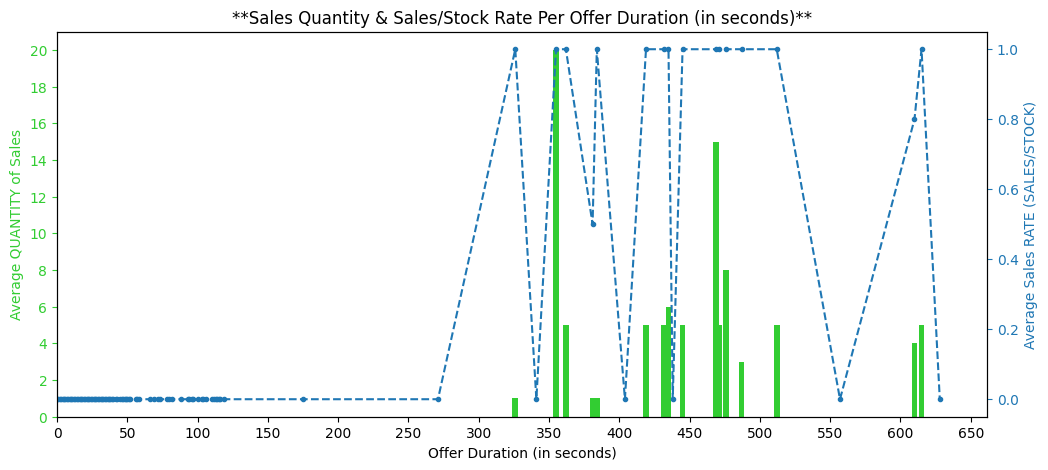

In [21]:
# First we summarize the data for plotting later.
df_duration_grp = df_clean[['offer_duration_seconds', 
                   'sales_rate', 
                   'sold_quantity_fixed'
                   ]].groupby('offer_duration_seconds'
                             ).agg(avg_sales_rate=('sales_rate','mean'),
                                   avg_sales_qty=('sold_quantity_fixed','mean')
                                   )


'''
We can now create the plot. Some details to keep in mind:
- Since `max(offer_duration_seconds) = 377,109`,  we will limit the plot to the smaller durations which is what we are mostly interested in.
- We will have offer_duration_seconds as our x-axis.
- We will have two y-axis:
        - left y-axis will represent the the average number of sales made (for each specific offer_duration_seconds). [GREEN BARS]
        - right (secondary) y-axis will represent the the average sales_rate (for each specific offer_duration_seconds). [BLUE LINE]
'''

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.set_title('**Sales Quantity & Sales/Stock Rate Per Offer Duration (in seconds)**')
ax1.bar(x=df_duration_grp[['avg_sales_qty']].reset_index()['offer_duration_seconds'].iloc[:100], 
        height=df_duration_grp[['avg_sales_qty']].reset_index()['avg_sales_qty'].iloc[:100],
        width=4,
        color='limegreen')
ax1.set_xlabel('Offer Duration (in seconds)')
ax1.set_ylabel('Average QUANTITY of Sales')
ax1.yaxis.label.set_color('limegreen')
ax1.tick_params(axis='y', colors='limegreen')
ax1.set_yticks(range(0, int(df_duration_grp['avg_sales_qty'].iloc[:100].max())+2,2))
ax1.set_xticks(range(0, round(int(df_duration_grp[['avg_sales_qty']].reset_index()['offer_duration_seconds'].iloc[:100].max()),-2)+100,50))
ax1.set_xlim(xmin=0)

ax2 = ax1.twinx()

ax2.plot(df_duration_grp['avg_sales_rate'].iloc[:100], '--', marker='.', c='#1f77b4')
ax2.set_ylabel('Average Sales RATE (SALES/STOCK)')
ax2.yaxis.label.set_color('#1f77b4')
ax2.tick_params(axis='y', colors='#1f77b4')


We can see right away that offers with `offer_duration_seconds < 300`, that is, **ofertas relâmpago that were active for less than 300 seconds (5 minutes) did not materialize any sales**.

Let's calculate how much of the data would be disconsidered if we were to drop those observations.

In [22]:
print(f'{len(df_clean[df_clean['offer_duration_seconds']<300])} observations with offer_duration_seconds < 300')
print(f'This represents {round(len(df_clean[df_clean['offer_duration_seconds']<300])/len(df_clean)*100,2)}% of the dataset.')

3748 observations with offer_duration_seconds < 300
This represents 7.84% of the dataset.


Only 7.84% of the dataset (3,748 observations) is compromised by this null duration offers.

We will proceed to exclude these rows.

In [23]:
df_clean = df_clean[df_clean['offer_duration_seconds']>=300]

# Validation
print(f'{len(df_clean[df_clean['offer_duration_seconds']<300])} observations with offer_duration_seconds < 300')

0 observations with offer_duration_seconds < 300


Considering that offer_duration_seconds is too granular and offer_duration_days is not granular enough, let's compare offer_duration_hours and offer_duration_minutes with sales to understand:
- Does offer duration impact sales_rate?
- Does offer duration impact sold_quantity?

##### Offer Duration in Hours

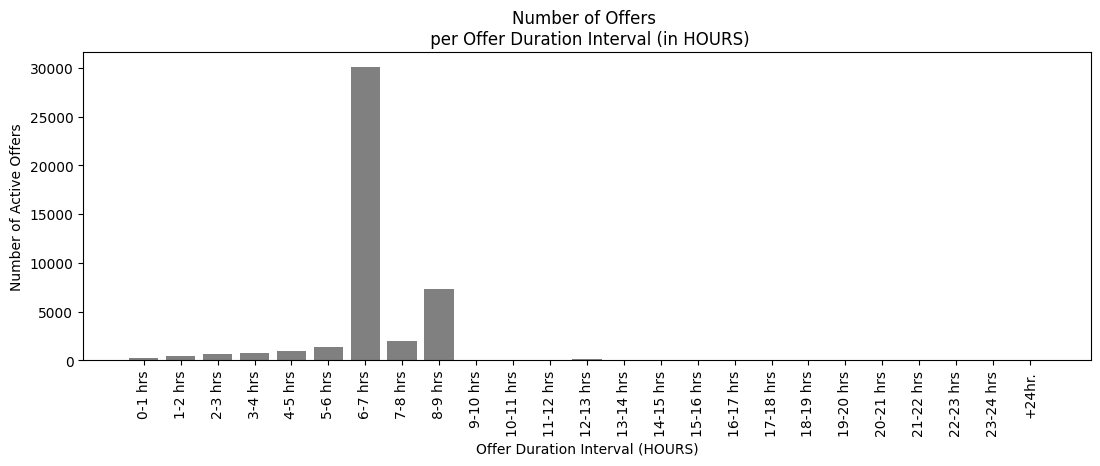

In [24]:
bins = list(range(-1,24))+[max(df_clean['offer_duration_hours'])]

df_duration_hrs = df_clean.copy()
df_duration_hrs['offer_duration_hours_bins'] = pd.cut(df_duration_hrs['offer_duration_hours'], bins=bins, right=True)
df_duration_hrs.reset_index(inplace=True)
df_duration_hrs.rename(columns={'index':'offer_id'}, inplace=True)
df_duration_hrs = df_duration_hrs[['offer_id','offer_duration_hours_bins','sales_rate','sold_quantity_fixed']]

df_duration_hrs_grp = df_duration_hrs.groupby('offer_duration_hours_bins').agg(num_offers=('offer_id','nunique'),
                                                                       avg_sales_rate=('sales_rate','mean'),
                                                                       avg_sold_quantity=('sold_quantity_fixed','mean')
                                                                       ).fillna(0).reset_index().reset_index()

df_duration_hrs_grp.rename(columns={'index':'hour_duration'}, inplace=True)

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

fig, ax1 = plt.subplots(figsize=(13,4))

ax1.set_title('Number of Offers \n per Offer Duration Interval (in HOURS)')
ax1.bar(x=df_duration_hrs_grp['hour_duration'], 
        height=df_duration_hrs_grp.reset_index()['num_offers'],
        color='gray')
ax1.set_xlabel('Offer Duration Interval (HOURS)')
ax1.set_ylabel('Number of Active Offers')
ax1.set_xticks(range(0,len(df_duration_hrs_grp)))
ax1.set_xticklabels([str(x)+'-'+str(x+1)+' hrs' for x in df_duration_hrs_grp.hour_duration[:-1]]+['+'+str(df_duration_hrs_grp.hour_duration.tolist()[-1])+'hr.'], rotation=90)
plt.show()


We see a big concentration of offers being active for more than 6 hours and less than 7 hours **(around 6 hours, when rounded down to the hour)**

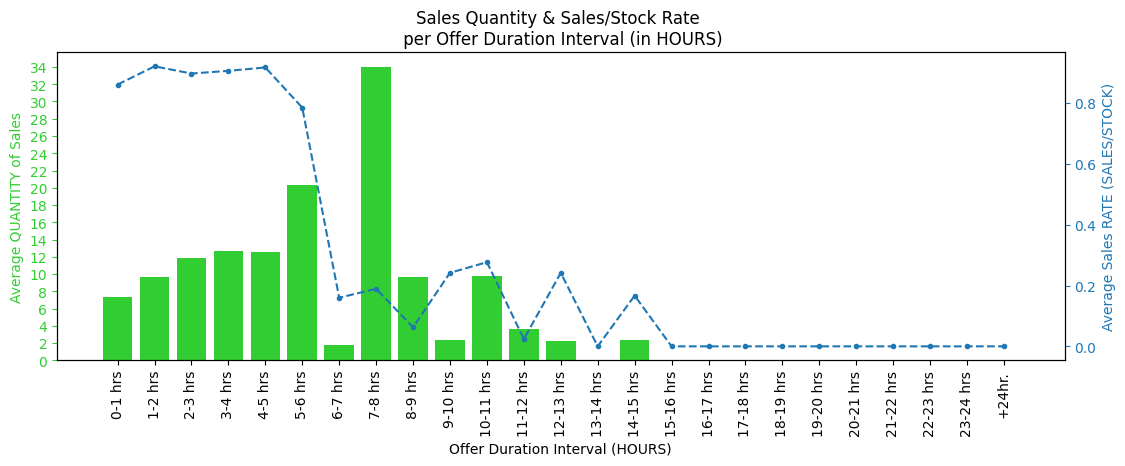

In [25]:
# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

fig, ax1 = plt.subplots(figsize=(13,4))

ax1.set_title('Sales Quantity & Sales/Stock Rate \n per Offer Duration Interval (in HOURS)')
ax1.bar(x=df_duration_hrs_grp['hour_duration'], 
        height=df_duration_hrs_grp.reset_index()['avg_sold_quantity'],
        #width=2,
        color='limegreen')
ax1.set_xlabel('Offer Duration Interval (HOURS)')
ax1.set_ylabel('Average QUANTITY of Sales')
ax1.yaxis.label.set_color('limegreen')
ax1.tick_params(axis='y', colors='limegreen')
ax1.set_yticks(range(0, int(df_duration_hrs_grp['avg_sold_quantity'].max())+2,2))
ax1.set_xticks(range(0,len(df_duration_hrs_grp)))
ax1.set_xticklabels([str(x)+'-'+str(x+1)+' hrs' for x in df_duration_hrs_grp.hour_duration[:-1]]+['+'+str(df_duration_hrs_grp.hour_duration.tolist()[-1])+'hr.'], rotation=90)
ax1.set_xticklabels([str(x)+'-'+str(x+1)+' hrs' for x in df_duration_hrs_grp.hour_duration[:-1]]+['+'+str(df_duration_hrs_grp.hour_duration.tolist()[-1])+'hr.'], rotation=90)
#ax1.set_xlim(xmin=0)

ax2 = ax1.twinx()

ax2.plot(df_duration_hrs_grp['avg_sales_rate'], '--', marker='.', c='#1f77b4')
ax2.set_ylabel('Average Sales RATE (SALES/STOCK)')
ax2.yaxis.label.set_color('#1f77b4')
ax2.tick_params(axis='y', colors='#1f77b4')

The graph above suggests that shorter durations create more urgency in clients to buy and thus increase the sales/stock rate.

We must keep in mind that the concentration in 6-7 hrs interval is pretty big.

##### Offer Duration in Minutes

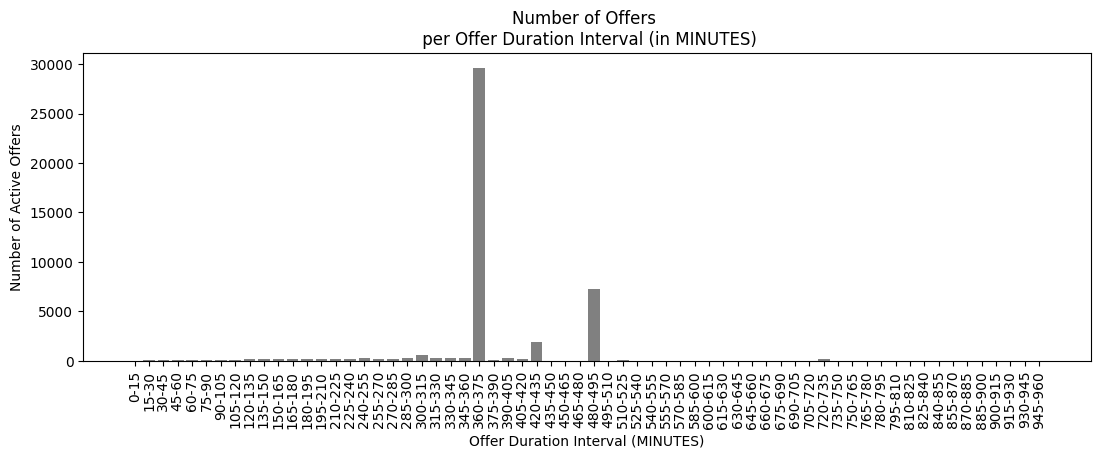

In [26]:
bins = list(range(0,16*60+1,15))

df_duration_min = df_clean.copy()
df_duration_min['offer_duration_minutes_bins'] = pd.cut(df_duration_min['offer_duration_minutes'], bins=bins, right=False)
df_duration_min.reset_index(inplace=True)
df_duration_min.rename(columns={'index':'offer_id'}, inplace=True)
df_duration_min = df_duration_min[['offer_id','offer_duration_minutes_bins','sales_rate','sold_quantity_fixed']]

df_duration_min_grp = df_duration_min.groupby('offer_duration_minutes_bins').agg(num_offers=('offer_id','nunique'),
                                                                                 avg_sales_rate=('sales_rate','mean'),
                                                                                 avg_sold_quantity=('sold_quantity_fixed','mean')
                                                                                 ).fillna(0).reset_index().reset_index()

df_duration_min_grp.rename(columns={'index':'hour_duration'}, inplace=True)

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

fig, ax1 = plt.subplots(figsize=(13,4))

ax1.set_title('Number of Offers \n per Offer Duration Interval (in MINUTES)')
ax1.bar(x=df_duration_min_grp['hour_duration'], 
        height=df_duration_min_grp.reset_index()['num_offers'],
        #width=2,
        color='gray')
ax1.set_xlabel('Offer Duration Interval (MINUTES)')
ax1.set_ylabel('Number of Active Offers')
ax1.set_xticks(range(0,len(df_duration_min_grp)))
ax1.set_xticklabels([str(x-15)+'-'+str(x) for x in bins[1:]], rotation=90)
plt.show()

On a more granular view, we can see that most of the offers had a duration between 360 minutes and 375 minutes **(which is around 6 hours as shown in the 'Offer Duration in Hours' analysis)**

This is a more granular confirmation of the concentration in the (rounded down) 6 hours offer duration.

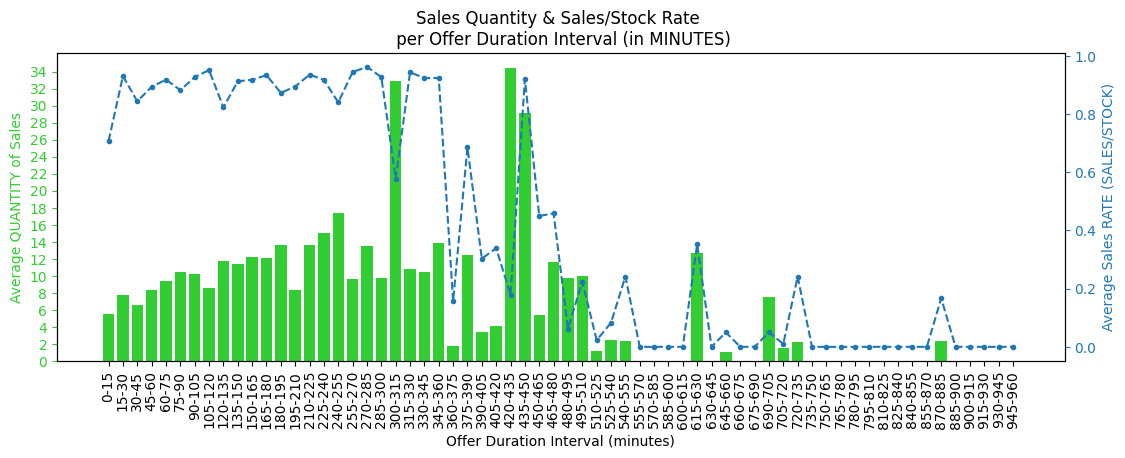

In [27]:
fig, ax1 = plt.subplots(figsize=(13,4))

ax1.set_title('Sales Quantity & Sales/Stock Rate \n per Offer Duration Interval (in MINUTES)')
ax1.bar(x=df_duration_min_grp['hour_duration'], 
        height=df_duration_min_grp.reset_index()['avg_sold_quantity'],
        #width=2,
        color='limegreen')
ax1.set_xlabel('Offer Duration Interval (minutes)')
ax1.set_ylabel('Average QUANTITY of Sales')
ax1.yaxis.label.set_color('limegreen')
ax1.tick_params(axis='y', colors='limegreen')
ax1.set_yticks(range(0, int(df_duration_min_grp['avg_sold_quantity'].max())+2,2))
ax1.set_xticks(range(0,len(bins)-1))
ax1.set_xticklabels([str(x-15)+'-'+str(x) for x in bins[1:]], rotation=90)
#ax1.set_xlim(xmin=0)

ax2 = ax1.twinx()

ax2.plot(df_duration_min_grp['avg_sales_rate'], '--', marker='.', c='#1f77b4')
ax2.set_ylabel('Average Sales RATE (SALES/STOCK)')
ax2.yaxis.label.set_color('#1f77b4')
ax2.tick_params(axis='y', colors='#1f77b4')


#### Weekday

Another feature we can engineer here is to extract the weekday from the offer start date and try to understand:
- Is there a concentration of ofertas relâmpago in specific days of the week?
- Does an oferta relâmpago have a higher sales_rate if activated in a specific day of the week?

`weekday == 0` ---> Monday

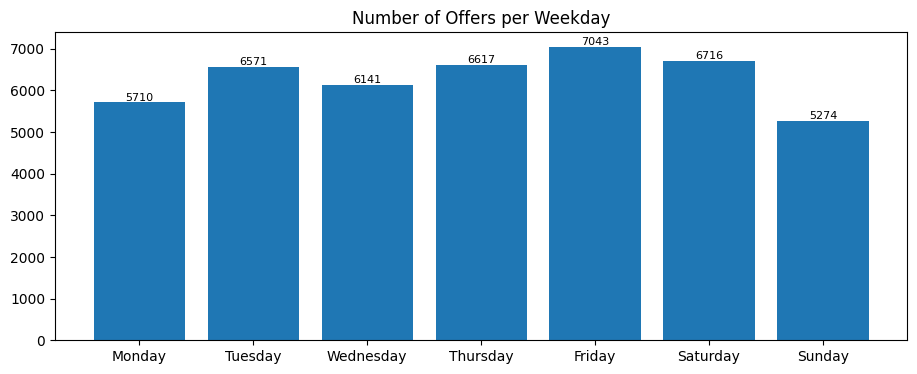

In [28]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_clean.head()
df_clean['offer_weekday'] = df_clean['OFFER_START_DTTM_dt'].dt.dayofweek

df_weekday_grp = df_clean[['offer_weekday','sales_rate','sold_quantity_fixed']].groupby('offer_weekday').agg(num_offers=('offer_weekday','count'),
                                                                                                             avg_sales_rate=('sales_rate','mean'),
                                                                                                             avg_sold_quantity=('sold_quantity_fixed','mean')
                                                                                                             ).fillna(0).reset_index()

df_weekday_grp['avg_sold_quantity'] = df_weekday_grp['avg_sold_quantity'].round(1)

df_weekday_grp['pct_offers'] = (df_weekday_grp['num_offers']/len(df_weekday_grp)).round(2)

#plt.figure(figsize=(11,4))
#plt.title('Number of Offers \n per Weekday')
#plt.bar(df_weekday_grp['offer_weekday'], df_weekday_grp['num_offers'])
#plt.xlabel('Weekday Number')
#plt.xticks(ticks=range(0,7), labels=weekdays)
#plt.bar_label(labels=bar_labels)
#plt.show()

fig, ax = plt.subplots(figsize=(11,4))
vbars = ax.bar(df_weekday_grp['offer_weekday'], df_weekday_grp['num_offers'])
ax.bar_label(vbars, fontsize=8)
plt.xticks(ticks=range(0,len(df_weekday_grp)), labels=weekdays)
plt.title('Number of Offers per Weekday')
plt.show()

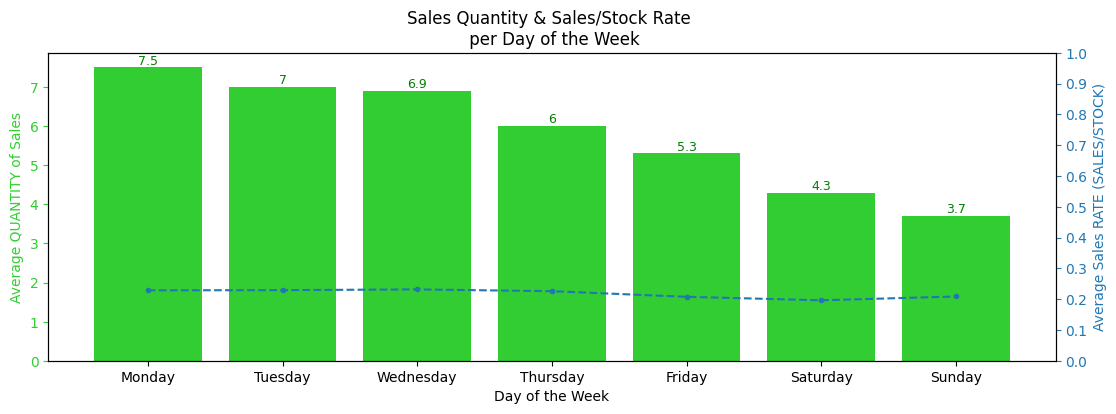

In [146]:
fig, ax1 = plt.subplots(figsize=(13,4))

ax1.set_title('Sales Quantity & Sales/Stock Rate \n per Day of the Week')
vbars = ax1.bar(x=df_weekday_grp['offer_weekday'], 
                height=df_weekday_grp.reset_index()['avg_sold_quantity'],
                color='limegreen')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Average QUANTITY of Sales')
ax1.yaxis.label.set_color('limegreen')
ax1.tick_params(axis='y', colors='limegreen')
ax1.bar_label(vbars, fontsize=9, color='green')

ax1.set_xticks(range(0,len(df_weekday_grp)))
ax1.set_xticklabels(weekdays)

ax2 = ax1.twinx()

ax2.plot(df_weekday_grp['avg_sales_rate'], '--', marker='.', c='#1f77b4')
ax2.set_yticks([x/10 if x!=0 else 0 for x in range(0,11)])
ax2.set_ylabel('Average Sales RATE (SALES/STOCK)')
ax2.yaxis.label.set_color('#1f77b4')
ax2.tick_params(axis='y', colors='#1f77b4')

Interesting to observe that, even though there is no concentration of offers on a specific day of the week and no real difference in average sales_rate, 
the average number of units sold is higher earlier in the week than later in the week

#### Hour of the day

Another feature we can engineer here is to extract the hour of the day of the offer start and try to understand:
- Is there a concentration of 'ofertas relâmpago' in specific 6 hour interval of the day?
- Does an 'oferta relâmpago' have a higher sales_rate if activated in a specific hour of the day?

PREMISE: Since we are analysing data on a hour level, to isolate offers with the same duration representing a big portion of the full dataset, we will use offers with `offer_duration_hours == 6`

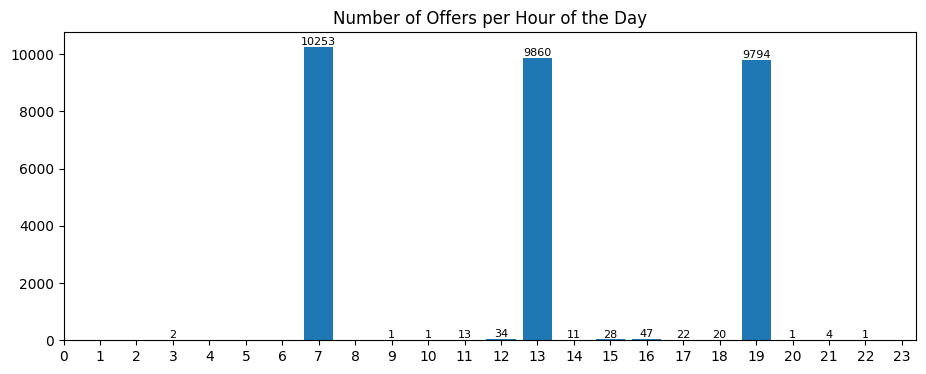

In [30]:
df_clean['hour_of_day'] = df_clean['OFFER_START_DTTM_dt'].dt.hour

df_hod = df_clean[df_clean['offer_duration_hours']==6].copy()

df_hod_grp = df_hod[['hour_of_day','sales_rate','sold_quantity_fixed']].groupby('hour_of_day').agg(num_offers=('hour_of_day','count'),
                                                                                                   avg_sales_rate=('sales_rate','mean'),
                                                                                                   avg_sold_quantity=('sold_quantity_fixed','mean')
                                                                                                   ).fillna(0).reset_index()

df_hod_grp['avg_sold_quantity'] = df_hod_grp['avg_sold_quantity'].round(1)

df_hod_grp['pct_offers'] = (df_hod_grp['num_offers']/len(df_hod_grp)).round(2)


fig, ax = plt.subplots(figsize=(11,4))
vbars = ax.bar(df_hod_grp['hour_of_day'], df_hod_grp['num_offers'])
ax.bar_label(vbars, fontsize=8)
plt.xticks(ticks=range(0,24))
plt.title('Number of Offers per Hour of the Day')
plt.show()


Right away we can see that there are three specific hours of the day that ofertas relâmpago usually start:
- 7am (7h) with 10,253
- 1pm (13h) with 9,860
- 7pm (19h) with 9,794

REMEMBER: These are all 6 hours duration offers.

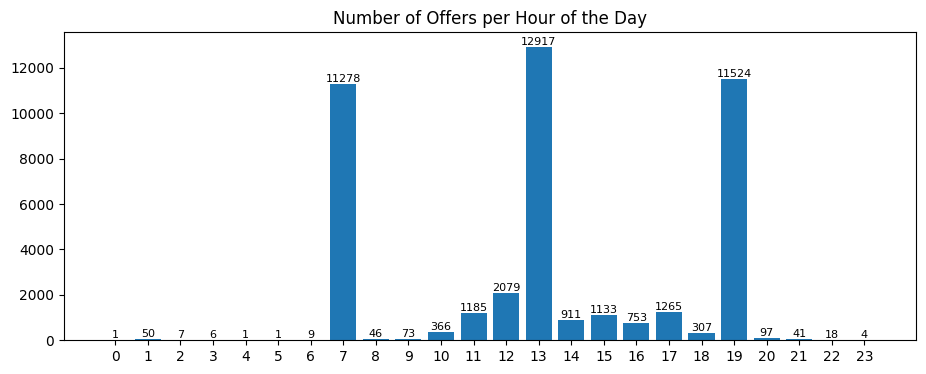

In [31]:
df_hod = df_clean.copy()

df_hod_grp = df_hod[['hour_of_day','sales_rate','sold_quantity_fixed']].groupby('hour_of_day').agg(num_offers=('hour_of_day','count'),
                                                                                                   avg_sales_rate=('sales_rate','mean'),
                                                                                                   avg_sold_quantity=('sold_quantity_fixed','mean')
                                                                                                   ).fillna(0).reset_index()

df_hod_grp['avg_sold_quantity'] = df_hod_grp['avg_sold_quantity'].round(1)

df_hod_grp['pct_offers'] = (df_hod_grp['num_offers']/len(df_hod_grp)).round(2)


fig, ax = plt.subplots(figsize=(11,4))
vbars = ax.bar(df_hod_grp['hour_of_day'], df_hod_grp['num_offers'])
ax.bar_label(vbars, fontsize=8)
plt.xticks(ticks=range(0,24))
plt.title('Number of Offers per Hour of the Day')
plt.show()


When looking at all observations, the concentration is maintained in the three most frequent hours of the day mentionde before: `7am`, `1pm`, and `7pm`.

Nevertheless, there is a significant number of offers from `10am` to `6pm` as well, especially at `12pm` (noon).

Let's see how the sales_rate behaves in this context:

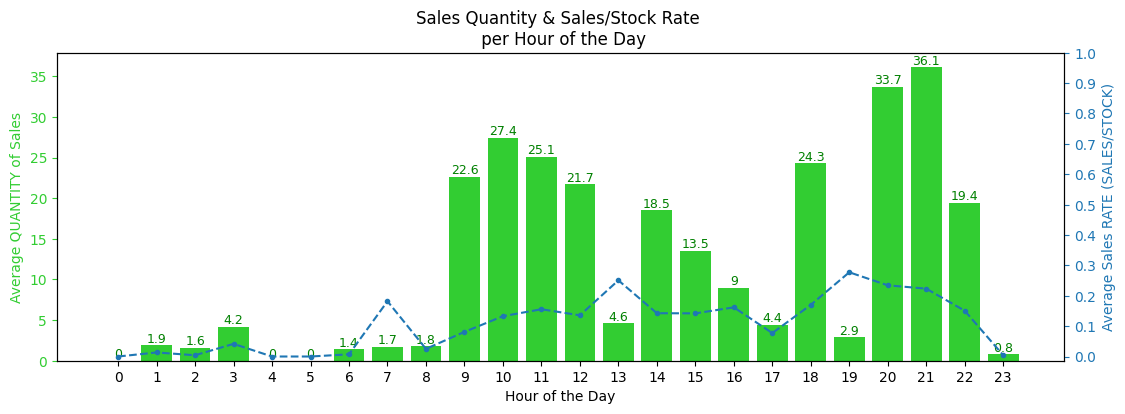

In [148]:
fig, ax1 = plt.subplots(figsize=(13,4))

ax1.set_title('Sales Quantity & Sales/Stock Rate \n per Hour of the Day')
vbars = ax1.bar(x=df_hod_grp['hour_of_day'], 
                height=df_hod_grp.reset_index()['avg_sold_quantity'],
                color='limegreen')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Average QUANTITY of Sales')
ax1.yaxis.label.set_color('limegreen')
ax1.tick_params(axis='y', colors='limegreen')
ax1.bar_label(vbars, fontsize=9, color='green')
ax1.set_xticks(range(0,len(df_hod_grp)))

ax2 = ax1.twinx()

ax2.plot(df_hod_grp['avg_sales_rate'], '--', marker='.', c='#1f77b4')
ax2.set_yticks([x/10 if x!=0 else 0 for x in range(0,11)])
ax2.set_ylabel('Average Sales RATE (SALES/STOCK)')
ax2.yaxis.label.set_color('#1f77b4')
ax2.tick_params(axis='y', colors='#1f77b4')

The graph above suggests that there are higher number of sales on average in the morning (from 9am to 12pm) and at the end of the day (from 8pm to 10pm) when looking at average number of sales.

Average sales_rate is relatively low trhoughout the day (from 9am to 10pm), ranging from around 10% to around 30%.

#### Correlation Analysis

Now that we have exhausted our feature engineering phase for `date` type features, let's calculate the correlation coefficients using some of the main methods:
- **Pearson Correlation**: linear correlation between two sets of numeric data;
- **Spearman Correlation**: linear correlation between the ranks of two sets of numeric data;
- **Correlation Ratio**: correlation between a categorical column and a numeric column;
- **Cramer’s V**: correlation between two categorical columns (based on the chi-squared metric).


Size of Correlation and Interpretation

.90 to 1.00 (−.90 to −1.00) ---> Very high positive (negative) correlation

.70 to .90 (−.70 to −.90) -----> High positive (negative) correlation

.50 to .70 (−.50 to −.70) -----> Moderate positive (negative) correlation

.30 to .50 (−.30 to −.50) -----> Low positive (negative) correlation

.20 to .30 (−.20 to −.30) -----> Very Low positive (negative) correlation

.00 to .20 (.00 to −.20) ------> negligible correlation


In [33]:
# Import the necessary modules and functions
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency


# Define correlation ratio function
def correlation_ratio(categorical_feature, numeric_feature):
    cats, freqs = np.unique(categorical_feature, return_counts=True)
    numeric_mean = np.mean(numeric_feature)
    sig_y_bar = 0
    for i in range(len(cats)):
        category_mean = np.mean(numeric_feature[categorical_feature == cats[i]])
        sig_y_bar += np.square(category_mean - numeric_mean) * freqs[i]
    sig_y = np.sum(np.square(numeric_feature - numeric_mean))
    statistic = np.sqrt(sig_y_bar / sig_y)
    return statistic

# Define Cramer's V function
def cramerv(a, b):
    contingency = pd.crosstab(index=[a], columns=[b])
    chi2 = chi2_contingency(contingency)[0]
    n = np.sum(contingency.values)
    r, k = contingency.shape
    statistic = np.sqrt((chi2 / n) / min(r - 1, k - 1))
    return statistic

# Define Cramer's V function
def cramerv_corrected(a, b):
    contingency = pd.crosstab(index=[a], columns=[b])
    chi2 = chi2_contingency(contingency)[0]
    n = np.sum(contingency.values)
    r, k = contingency.shape
    phi2 = chi2 / n
    
    phi2_corrected = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
    r_corrected = r - (r - 1) ** 2 / (n - 1)
    k_corrected = k - (k - 1) ** 2 / (n - 1)
    
    statistic = np.sqrt(phi2_corrected / min(r_corrected - 1, k_corrected - 1))
    return statistic


def correl_level(corr):
    if corr == 0:
        return 'NO CORRELATION'
    elif abs(corr) <= 0.2:
        level = 'NEGLIGIBLE'
    elif abs(corr) <= 0.3:
        level = 'VERY LOW'
    elif abs(corr) <= 0.5:
        level = 'LOW'
    elif abs(corr) <= 0.7:
        level = 'MODERATE'
    elif abs(corr) <= 0.9:
        level = 'HIGH'
    elif abs(corr) < 1:
        level = 'VERY HIGH'
    elif abs(corr) == 1:
        level = 'PERFECT'
    else:
        return 'ERROR'
    
    if corr > 0:
        direction = 'positive'
    else:
        direction = 'negative'

    return f'{level} {direction} correl.'

In [34]:
#corr, _ = spearmanr(a, b)
#corr, _ = pearsonr(a, b)
#corr = correlation_ratio(a, b)
#corr = cramerv(a, b)
#corr = cramerv_corrected(a, b)

In [35]:
def correl_analysis(feat_a, df=df_clean, feat_b='sales_rate'):            
    a = df[feat_a]
    b = df[feat_b]

    if pd.api.types.is_numeric_dtype(df[feat_a].dtype) and pd.api.types.is_numeric_dtype(df[feat_b].dtype):

        print_header(f'{feat_a.upper()} x {feat_b.upper()}')
        print(f'PEARSON CORRELATION:\t{round(pearsonr(a, b)[0],2)} (p-value={round(spearmanr(a, b)[1],4)}) \t {correl_level(pearsonr(a, b)[0])}')
        print(f'SPEARMAN CORRELATION:\t{round(spearmanr(a, b)[0],2)} (p-value={round(spearmanr(a, b)[1],4)}) \t {correl_level(spearmanr(a, b)[0])}')
    
    elif (pd.api.types.is_object_dtype(df[feat_a].dtype) 
          and pd.api.types.is_numeric_dtype(df[feat_b].dtype)
          ) or (
          pd.api.types.is_numeric_dtype(df[feat_a].dtype) 
          and pd.api.types.is_object_dtype(df[feat_b].dtype)):
        
        pass # CORRELATION RATIO

    elif pd.api.types.is_object_dtype(df[feat_a].dtype) and pd.api.types.is_object_dtype(df[feat_b].dtype):
        pass # CRAMER'S V

Initially we will calculate each of the following features' correlation with sales (both `sales_rate` and `sold_quantity_fixed`).

In [36]:
feat_a_cols = [
    
    'unit_price',
    #'remaining_stock_after_end_fixed',
    #'sold_amount_fixed',

    'offer_duration_seconds',
    'offer_duration_minutes',
    'offer_duration_hours',
    'offer_duration_days',

    'offer_weekday',
    'hour_of_day'
 ]

**CORRELATION WITH 'sales_rate'**

In [37]:
for feat_a in feat_a_cols:
    correl_analysis(feat_a=feat_a, df=df_clean, feat_b='sales_rate')


-------------------------------------- UNIT_PRICE x SALES_RATE -------------------------------------
PEARSON CORRELATION:	0.07 (p-value=0.0) 	 NEGLIGIBLE positive correl.
SPEARMAN CORRELATION:	0.78 (p-value=0.0) 	 HIGH positive correl.

-------------------------------- OFFER_DURATION_SECONDS x SALES_RATE -------------------------------
PEARSON CORRELATION:	-0.48 (p-value=0.0) 	 LOW negative correl.
SPEARMAN CORRELATION:	-0.32 (p-value=0.0) 	 LOW negative correl.

-------------------------------- OFFER_DURATION_MINUTES x SALES_RATE -------------------------------
PEARSON CORRELATION:	-0.48 (p-value=0.0) 	 LOW negative correl.
SPEARMAN CORRELATION:	-0.38 (p-value=0.0) 	 LOW negative correl.

--------------------------------- OFFER_DURATION_HOURS x SALES_RATE --------------------------------
PEARSON CORRELATION:	-0.53 (p-value=0.0) 	 MODERATE negative correl.
SPEARMAN CORRELATION:	-0.4 (p-value=0.0) 	 LOW negative correl.

---------------------------------- OFFER_DURATION_DAYS x SALES_RA

As we can see, most numeric features have Low or Negligible correlation with `sales_rate`. We will focus on those that have at least a MODERATE correlation:

- UNIT_PRICE x SALES_RATE: are highly positively correlated when looking at the Spearman correlation, that is, the rank of the two variables are highly correlated.
- OFFER_DURATION_HOURS x SALES_RATE: have a moderate negative correlation when looking at the Pearson correlation, that is, when `offer_duration_hours` goes up, `sales_rate` goes down (which we visualized earlier in the notebook).

(The p-value for the mentioned correlations is very low, adding statistical relevance to the relationship observed).

**CORRELATION WITH 'sold_quantity_fixed'**

In [38]:
for feat_a in feat_a_cols:
    correl_analysis(feat_a=feat_a, df=df_clean, feat_b='sold_quantity_fixed')


---------------------------------- UNIT_PRICE x SOLD_QUANTITY_FIXED ---------------------------------
PEARSON CORRELATION:	-0.0 (p-value=0.0) 	 NEGLIGIBLE negative correl.
SPEARMAN CORRELATION:	0.77 (p-value=0.0) 	 HIGH positive correl.

---------------------------- OFFER_DURATION_SECONDS x SOLD_QUANTITY_FIXED ---------------------------
PEARSON CORRELATION:	0.02 (p-value=0.0) 	 NEGLIGIBLE positive correl.
SPEARMAN CORRELATION:	-0.22 (p-value=0.0) 	 VERY LOW negative correl.

---------------------------- OFFER_DURATION_MINUTES x SOLD_QUANTITY_FIXED ---------------------------
PEARSON CORRELATION:	0.02 (p-value=0.0) 	 NEGLIGIBLE positive correl.
SPEARMAN CORRELATION:	-0.25 (p-value=0.0) 	 VERY LOW negative correl.

----------------------------- OFFER_DURATION_HOURS x SOLD_QUANTITY_FIXED ----------------------------
PEARSON CORRELATION:	0.01 (p-value=0.0) 	 NEGLIGIBLE positive correl.
SPEARMAN CORRELATION:	-0.27 (p-value=0.0) 	 VERY LOW negative correl.

----------------------------- OF

Now, when looking at `sold_quantity_fixed` and it's correlation with the other features, we can see only one relevant correlation:

- UNIT_PRICE x SOLD_QUANTITY_FIXED: are highly positively correlated when looking at the Spearman correlation, that is, the rank of the two variables are highly correlated.

(The p-value for the mentioned correlations is very low, adding statistical relevance to the relationship observed).

#### What can we extract from these CORRELATION results?

- Unit price seems to have a relationship with how much of the stock is sold and how many units in total are sold as well. We can intuitively accept that considering that cheaper products tend to be sold more easily.
- Offer duration (in hours) also has shown to have some relationship with sales, specifically with the sales rate (sold units/involved stock). This suggests that the more urgency you create in your offers, the more likely you will be to sell your units.

## Numeric Columns and their values

In [39]:
df_clean.select_dtypes(include='number').dtypes

INVOLVED_STOCK                               int64
sold_quantity_fixed                          int64
remaining_stock_after_end_fixed              int64
unit_price                                 float64
sold_amount_fixed                          float64
sales_rate                                 float64
offer_duration                     timedelta64[ns]
offer_duration_seconds                       int64
offer_duration_minutes                       int64
offer_duration_hours                         int64
offer_duration_days                          int64
offer_weekday                                int32
hour_of_day                                  int32
dtype: object

#### unit_price

We will start with unit_price, for we still have a pending task related to it.

- When creating this feature, we devided the sold_amount_fixed by the sold_quantity_fixed.
- Many cases though did not have any sales, thus causing the calculated unit_price to be 0 (which cannot be right).
- Lucky for us, we have other variables that could help us estimate the unit_price for those offers with no sales.
- We could simply use the mean or median of all unit_price's greater than 0, but we can sophisticate this further.
- There are three columns that we can take advantage of for this: 
    - VERTICAL
    - DOM_DOMAIN_AGG1
    - DOMAIN_ID

Here we will fill na with the mean price of the obervations with same `VERTICAL`, `DOM_DOMAIN_AGG1`, and `DOMAIN_ID`.

If all obervations of the same 3 variables are null, we will fill na with the mean price of the obervations with same `VERTICAL`, and `DOM_DOMAIN_AGG1`.

If all obervations of the same 2 variables are null, we will fill na with the mean price of the obervations with same `VERTICAL`.


In [61]:
df_temp = df_clean[['unit_price']].copy()
df_temp['has_unit_price'] = df_clean['unit_price']>0
df_temp = df_temp.reset_index().rename(columns={'index':'offer_id'})
print(df_temp.groupby('has_unit_price').agg(num_offers=('offer_id','nunique')).reset_index())

   has_unit_price  num_offers
0           False       19524
1            True       24548


We have 19.5k cases with unit_price == 0

Now that we have identified the opportunity to increase data quality for close to half of the dataset, let's apply it to df_clean

In [99]:
# We start by creating a copy of the unit_price that will be fixed, so we will call it unit_price_fixed
# we will also already set all 0 values to np.nan, so we can fill them with the correct estimated value
df_clean['unit_price_fixed'] = df_clean['unit_price'].replace(0, np.nan)

# Let's print the number of na values before the fill na iterations:
print(f'num null values before fixing:\t\t {df_clean['unit_price_fixed'].isnull().sum():,}')

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

# Now we will fill na with the average of each category combination ('VERTICAL', 'DOM_DOMAIN_AGG1', and 'DOMAIN_ID')
df_clean['unit_price_fixed'].fillna(df_clean.groupby(['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID'])['unit_price_fixed']
                                    .transform("mean"),
                                    inplace=True)

# Let's print the number of na values after first fill na iteration:
print(f'num null values after first fillna:\t {df_clean['unit_price_fixed'].isnull().sum():,}')

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

# Now we will fill na with the average of each category combination ('VERTICAL', 'DOM_DOMAIN_AGG1', and 'DOMAIN_ID')
df_clean['unit_price_fixed'].fillna(df_clean.groupby(['VERTICAL','DOM_DOMAIN_AGG1'])['unit_price_fixed']
                                    .transform("mean"),
                                    inplace=True)


# Let's print the number of na values after second fill na iteration:
print(f'num null values after second fillna:\t {df_clean['unit_price_fixed'].isnull().sum():,}')

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

# Now we will fill na with the average of each category combination ('VERTICAL', 'DOM_DOMAIN_AGG1', and 'DOMAIN_ID')
df_clean['unit_price_fixed'].fillna(df_clean.groupby(['VERTICAL'])['unit_price_fixed']
                                    .transform("mean"),
                                    inplace=True)


# Let's print the number of na values after third fill na iteration:
print(f'num null values after third fillna:\t {df_clean['unit_price_fixed'].isnull().sum():,}')

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

num null values before fixing:		 19,524
num null values after first fillna:	 639
num null values after second fillna:	 1
num null values after third fillna:	 0


Now we have successfully filled the unit_prices = 0 with the most possible granular average based on the 'VERTICAL','DOM_DOMAIN_AGG1', and 'DOMAIN_ID'.

Let's plot the new/fixed data.

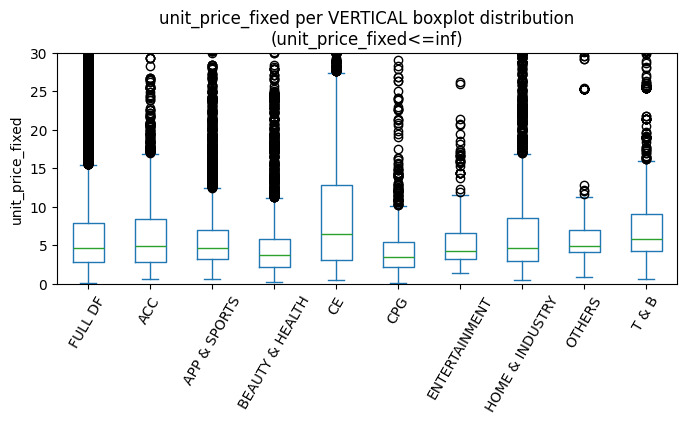

In [198]:
# BOXPLOT for 'unit_price_fixed' per 'VERTICAL' category
relative_boxplot(df=df_clean, main_var='VERTICAL', comparison_var='unit_price_fixed', threshold=np.inf)
plt.xticks(rotation=60)
plt.show()

In [199]:
df_clean[['unit_price', 'unit_price_fixed']].describe()

,unit_price,unit_price_fixed
count,44072.000000,44072.000000
mean,4.891767,9.679268
std,17.003702,23.068201
min,0.000000,0.121333
25%,0.000000,2.870000
50%,1.420000,4.650000
75%,4.430000,7.913276
max,639.070000,639.070000


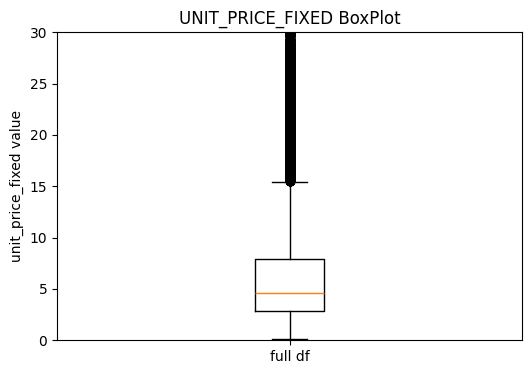

In [214]:
simple_boxplot(df=df_clean, var='unit_price_fixed')


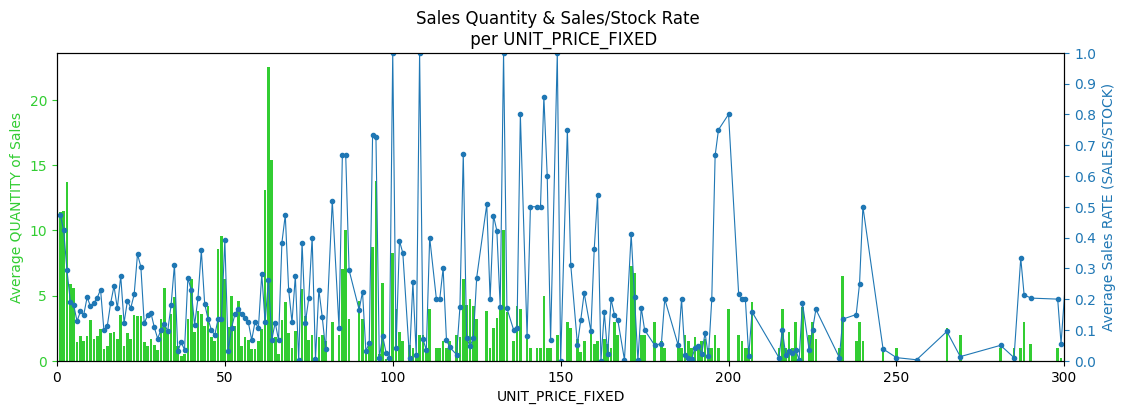

In [150]:
relative_sales_sublots(df=df_clean, x='unit_price_fixed', min_x=0, max_x=300)
#relative_sales_sublots(df=df_clean, x='unit_price_fixed', min_x=300, max_x=int(df_clean.unit_price_fixed.max()))

In [156]:
feat_a = 'unit_price_fixed'

for feat_b in ['sales_rate', 'sold_quantity_fixed']:
    correl_analysis(feat_a=feat_a, df=df_clean, feat_b=feat_b)


----------------------------------- UNIT_PRICE_FIXED x SALES_RATE ----------------------------------
PEARSON CORRELATION:	-0.09 (p-value=0.0) 	 NEGLIGIBLE negative correl.
SPEARMAN CORRELATION:	-0.24 (p-value=0.0) 	 VERY LOW negative correl.

------------------------------- UNIT_PRICE_FIXED x SOLD_QUANTITY_FIXED ------------------------------
PEARSON CORRELATION:	-0.04 (p-value=0.0) 	 NEGLIGIBLE negative correl.
SPEARMAN CORRELATION:	-0.26 (p-value=0.0) 	 VERY LOW negative correl.


As we can see visually in the bar + line plot and through the correlation analysis: 
- there is no significant correlation between `unit_price_fixed` and either `sales_rate` and `sold_quantity_fixed`

#### INVOLVED_STOCK

We will see how the `INVOLVED_STOCK` variable is distributed in our dataset, that is:
- We will see (through the `.desctibe()` method and a boxplot) how much stock the ofertas relâmpago usually (an unusually) have.
- Correlation (through a scatter plot and a correlation coefficient) with sales_rate and unit_price (once we have fixed the unit_price==0 cases).

In [171]:
df_clean[['INVOLVED_STOCK']].describe().round(2)

,INVOLVED_STOCK
count,44072.00
mean,36.65
std,216.08
min,1.00
25%,5.00
50%,10.00
75%,15.00
max,9000.00


We have ofertas relâmpago containing stock:
- from 1 unit to 9,000 units.
- average stock = 37 units
- median stock = 10 units

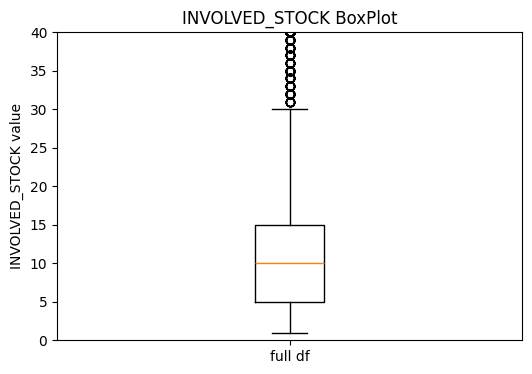

In [213]:
simple_boxplot(df=df_clean, var='INVOLVED_STOCK')

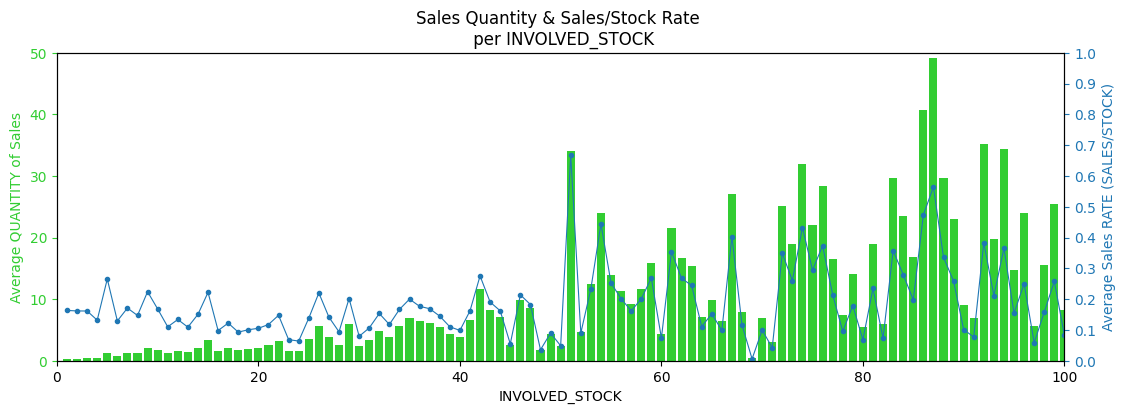

In [232]:
relative_sales_sublots(df=df_clean, x='INVOLVED_STOCK', min_x=0, max_x=100, min_y=0, max_y=50)

#type(df_clean['INVOLVED_STOCK'][0])

In [215]:
feat_a = 'INVOLVED_STOCK'

for feat_b in ['sales_rate', 'sold_quantity_fixed']:
    correl_analysis(feat_a=feat_a, df=df_clean, feat_b=feat_b)


------------------------------------ INVOLVED_STOCK x SALES_RATE -----------------------------------
PEARSON CORRELATION:	-0.03 (p-value=0.7447) 	 NEGLIGIBLE negative correl.
SPEARMAN CORRELATION:	0.0 (p-value=0.7447) 	 NEGLIGIBLE positive correl.

-------------------------------- INVOLVED_STOCK x SOLD_QUANTITY_FIXED -------------------------------
PEARSON CORRELATION:	0.58 (p-value=0.0) 	 MODERATE positive correl.
SPEARMAN CORRELATION:	0.24 (p-value=0.0) 	 VERY LOW positive correl.


(0.0, 100.0)

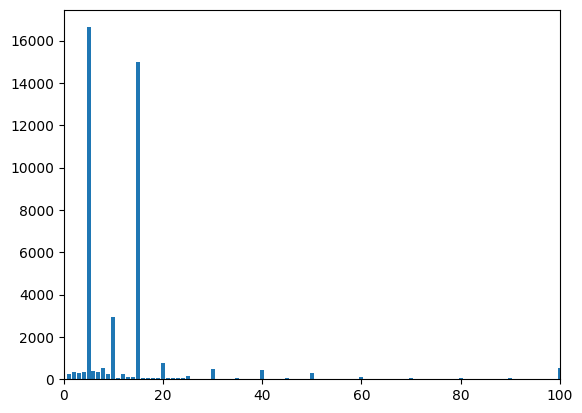

In [241]:
def simple_barplot(df, var):
    fig, ax = plt.subplots()
    ax.bar(df[[var]].groupby(var).agg(num_offers=(var,'count')).reset_index()[var],
                    df[[var]].groupby(var).agg(num_offers=(var,'count')).reset_index()['num_offers'])
    
    # STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - STOPPED HERE - 
    #ax.set_ylim(0,100)
    ax.set_xlim(0,100)


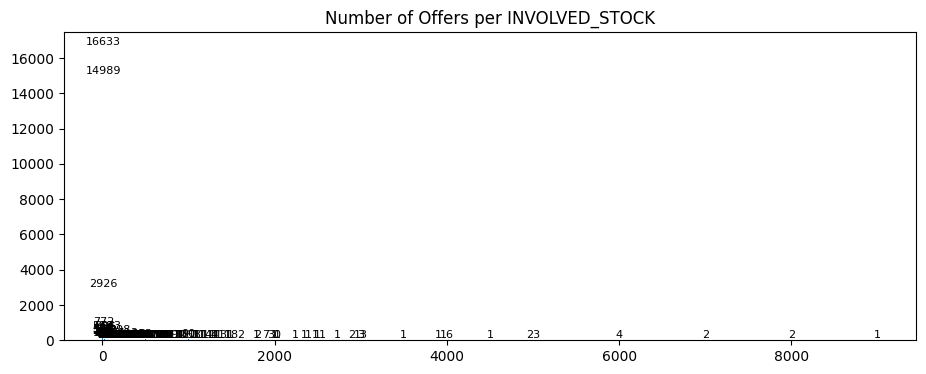

In [236]:

    df_temp_grp = df_clean[[var,'sales_rate','sold_quantity_fixed']].groupby(var).agg(num_offers=(var,'count')).fillna(0).reset_index()

    fig, ax = plt.subplots(figsize=(11,4))
    vbars = ax.bar(df_temp_grp[var], df_temp_grp['num_offers'])
    ax.bar_label(vbars, fontsize=8)
    #plt.xticks(ticks=range(0,24))
    plt.title('Number of Offers per '+var.upper())
    plt.show()

simple_barplot(df=df_clean, var='INVOLVED_STOCK')
#plt.ylim([0,40])
#plt.xlim([0,40])

#### sold_quantity_fixed

We will see how the `sold_quantity_fixed` variable is distributed in our dataset, that is:
- We will see (through the `.desctibe()` method and a boxplot) how much stock the ofertas relâmpago usually (an unusually) have.
- Outliers
- Correlation (through a scatter plot and a correlation coefficient) with sales_rate and unit_price (once we have fixed the unit_price==0 cases).

#### sold_amount_fixed

#### remaining_stock_after_end_fixed

#### sales_rate

## Categorical Variables and their values

In [43]:
'''
First we will create a function to create a boxplot 
for each category for a given categorical variable (main_var) 
and a given numerical var (comparison_var).

We will basically try to understand the different distributions of a numerical variable 
for the different values/categories of a categorical variable.
'''

def relative_boxplot(df, main_var, comparison_var, threshold=np.inf):

    df_temp = df[[main_var, comparison_var]].copy()
    
    df_temp_pvt = df_temp[df_temp[comparison_var]<=threshold].pivot(values=comparison_var, columns=main_var)
    new_cols = df_temp_pvt.columns.tolist()
    df_temp_pvt['FULL DF'] = df_temp_pvt.fillna(0).sum(axis=1, numeric_only=True)
    df_temp_pvt = df_temp_pvt[['FULL DF']+new_cols]

    df_temp_pvt.plot(kind='box', figsize=(8,3))
    plt.title(f'{comparison_var} per {main_var} boxplot distribution\n({comparison_var}<={threshold})')
    plt.ylabel(comparison_var)
    
    if int(df_temp[comparison_var].max()) <= 1:
        pass
    elif (int(df_temp.describe().loc['75%',comparison_var])+int(df_temp.describe().loc['std',comparison_var]*1)) <= 99:
        plt.ylim([0,
                #round((int(df_temp.describe().loc['75%',comparison_var])+int(df_temp.describe().loc['std',comparison_var]*2)),-1)
                round((int(df_temp.describe().loc['75%',comparison_var])+int(df_temp.describe().loc['std',comparison_var]*1)),-1)
                ])
    else:
        plt.ylim([0,
                round((int(df_temp.describe().loc['75%',comparison_var])+int(df_temp.describe().loc['std',comparison_var]*1)),-2)
                ])


'''
The vars we want to compare with a categorical variable are related with stock, price, and sales.
'''
comparison_vars = ['INVOLVED_STOCK', 'unit_price', 'sales_rate', 'sold_quantity_fixed']

In [44]:
categ_var = 'ORIGIN'

#df_temp_grp = df_clean.reset_index().rename(columns={'index':'offer_id'})[['offer_id', categ_var]].groupby(categ_var).agg(num_offers=('offer_id','count'))

df_temp_grp = df.reset_index().rename(columns={'index':'offer_id'})[['offer_id', categ_var]].groupby(categ_var).agg(num_offers=('offer_id','count'))

#fig, ax = plt.subplots(figsize=(11,4))
#vbars = ax.bar(df_temp_grp[categ_var], df_temp_grp['num_offers'])
#ax.bar_label(vbars, fontsize=8)
#plt.xticks(ticks=range(0,24))
#plt.title(f'Number of Offers per {categ_var.upper()}')
#plt.show()

### ORIGIN

We have analysed the ORIGIN feature. Let us isolate that information here.

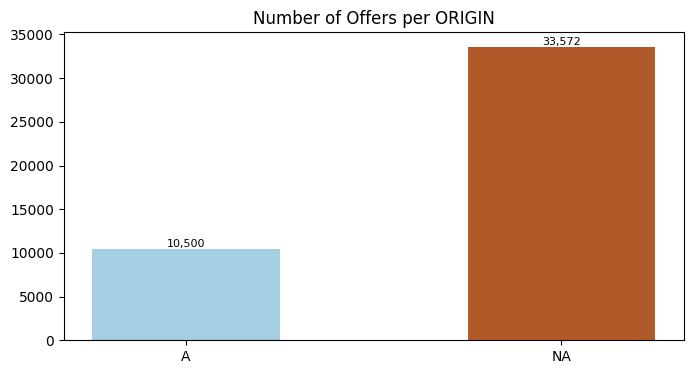

In [46]:
categ_var_analysis(df=df_clean, categ_var='ORIGIN')

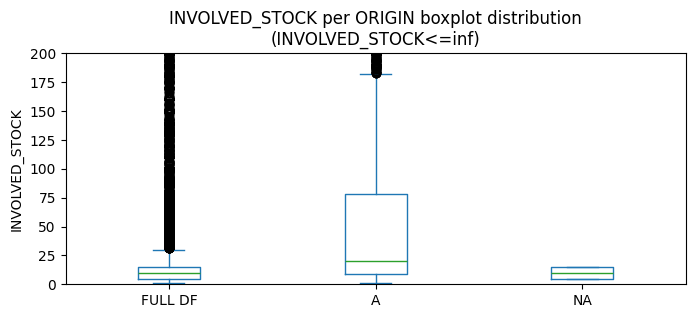

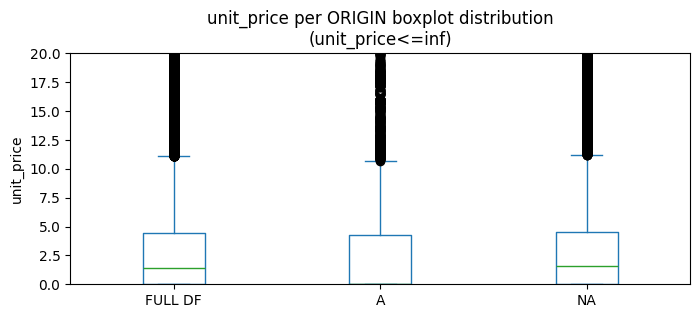

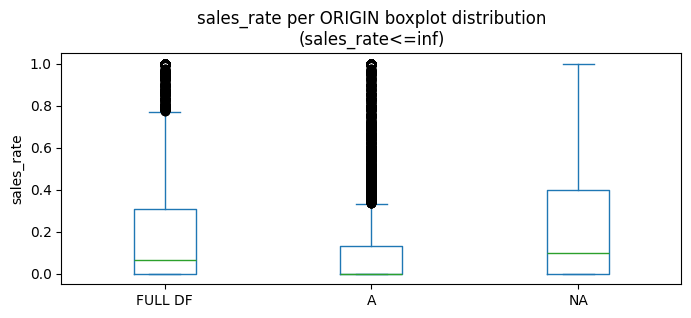

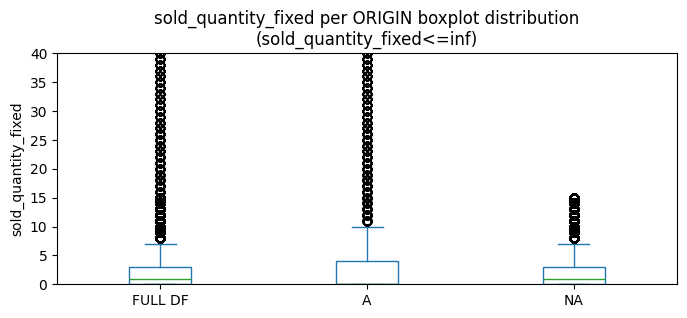

In [47]:
for comparison_var in comparison_vars: 
    relative_boxplot(df=df_clean, main_var='ORIGIN', comparison_var=comparison_var, threshold=np.inf)


I have limited the y-axis to be able to properly visualize the boxplots, considering that there are many outliers in the data for most columns.

With that being said, there is considerable difference between observations with `ORIGIN='A'` and observations with `ORIGIN` missing (now `ORIGIN='NA'`):
- `INVOLVED_STOCK`: `ORIGIN='A'` observations are much more spread out than the other observations for this variable. Offers of `ORIGIN='A'` usually have more involved stock.
- `sales_rate`: `ORIGIN='A'` observations are less spread out than the ohter observations for sales_rate. Offers of `ORIGIN='A'` have lower sales_rate then the other offers (probably related to the higher number of units in stock).
- `sold_quantity_fixed` and `unit_price`: There is a slight difference but nothing too significant.

### SHIPPING_PAYMENT_TYPE

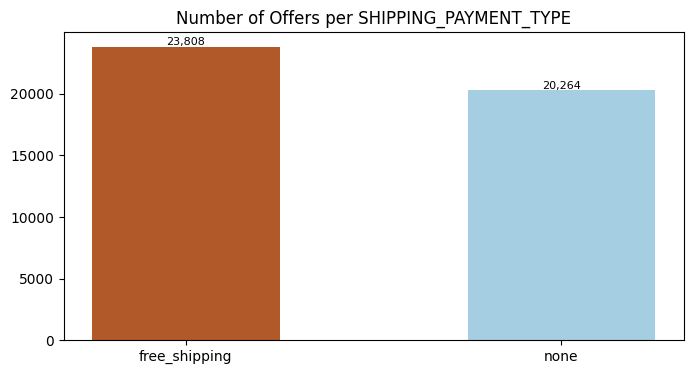

In [48]:
categ_var_analysis(df=df_clean, categ_var='SHIPPING_PAYMENT_TYPE')

Here we can see two categories in the `SHIPPING_PAYMENT_TYPE`: 
- 'free_shipping': containing 23,808 observations.
- 'none': containing the remaining 20,264 observations.

Let's see if there is a difference in sales, stock, and price between these two categories.

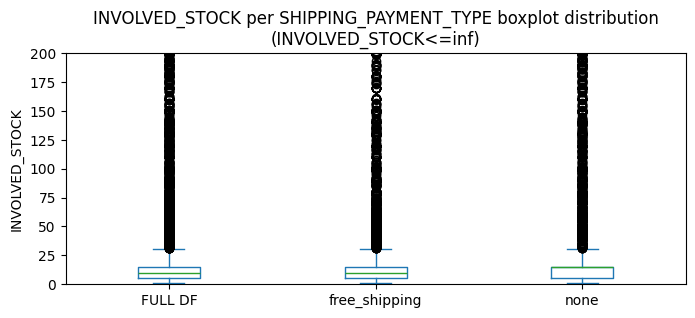

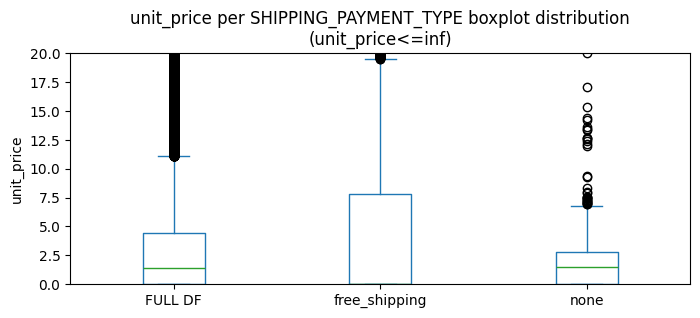

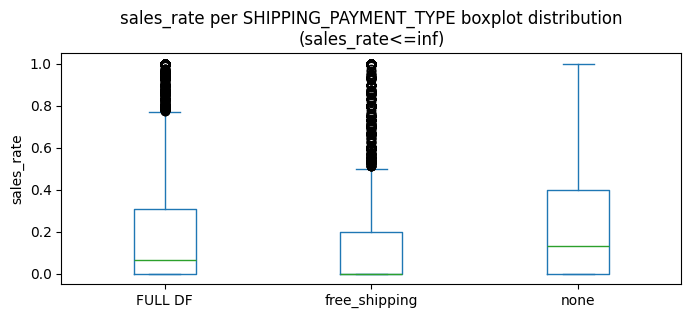

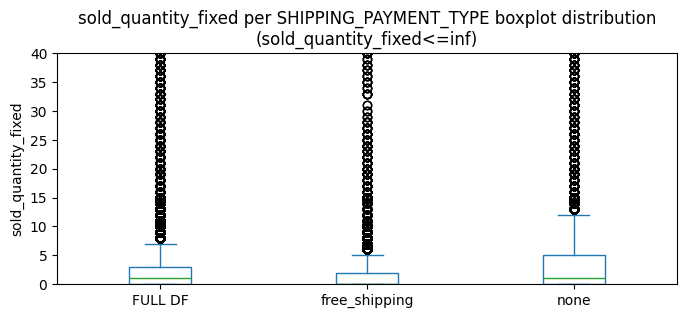

In [49]:
for comparison_var in comparison_vars: 
    relative_boxplot(df=df_clean, main_var='SHIPPING_PAYMENT_TYPE', comparison_var=comparison_var, threshold=np.inf)

### VERTICAL, DOM_DOMAIN_AGG1, and DOMAIN_ID

In [ ]:
# USER DEFINED FUNCTION that creates the table above

def summary_table_categ_var(df, categ_var, num_var):
    
    if isinstance(categ_var, list):
        df_temp = df_clean[categ_var+[num_var]].sort_values(categ_var).copy()
        df_temp.groupby(categ_var).agg(avg_num_var=(num_var,'mean'),
                                       std_num_var=(num_var,'std'),
                                       var_num_var=(num_var,'var'),
                                       median_num_var=(num_var,'median'),
                                       min_num_var=(num_var,'min'),
                                       max_num_var=(num_var,'max')
                                       ).reset_index().sort_values('avg_num_var',ascending=False)
        
    elif isinstance(categ_var, str):
        df_temp = df_clean[[categ_var]+[num_var]].sort_values(categ_var).copy()
        df_temp.groupby(categ_var).agg(avg_num_var=(num_var,'mean'),
                                       std_num_var=(num_var,'std'),
                                       var_num_var=(num_var,'var'),
                                       median_num_var=(num_var,'median'),
                                       min_num_var=(num_var,'min'),
                                       max_num_var=(num_var,'max')
                                       ).reset_index().sort_values('avg_num_var',ascending=False)
    else:
        raise ValueError('categ_var is not a list or a string, or categ_var list/string does not exist in df')

In [74]:
for vert in df_clean['VERTICAL'].unique():
    print_header(vert.upper())
    for dom_agg in df_clean[df_clean['VERTICAL']==vert].DOM_DOMAIN_AGG1.unique().tolist():
        print(f'{dom_agg} {'- '*(50-len(dom_agg))}')
        print(df_clean[(df_clean['VERTICAL']==vert) & (df_clean['DOM_DOMAIN_AGG1']==dom_agg)].DOMAIN_ID.unique())


------------------------------------------------ CPG -----------------------------------------------
PETS FOOD - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
['MLM-BIRD_FOODS' 'MLM-CATS_AND_DOGS_FOODS' 'MLM-FISH_FOODS'
 'MLM-DOG_SUPPLEMENTS' 'MLM-CATS_AND_DOGS_TREATS']
DRINKS - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
['MLM-BEERS' 'MLM-GINGER' 'MLM-WINES' 'MLM-WHISKEYS' 'MLM-TEQUILAS'
 'MLM-ENERGY_DRINKS' 'MLM-MINERAL_WATERS' 'MLM-JUICES']
FOODS - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
['MLM-TEA' 'MLM-CACAO' 'MLM-HONEY' 'MLM-CANDIES' 'MLM-CHOCOLATES'
 'MLM-SWEETENERS' 'MLM-FOODS_AND_DRINKS' 'MLM-SAUCES_AND_DRESSINGS'
 'MLM-FLOUR' 'MLM-PASTAS' 'MLM-DRIED_FRUITS'
 'MLM-CANNED_AND_PRESERVED_FOOD' 'MLM-SPICES' 'MLM-VINEGARS'
 'MLM-PEANUT_BUTTERS' 'MLM-EDIBLE_SEAWEEDS'
 'MLM-GROUND_AND_WHOLE_BEANS_COFFEE' 'MLM-MILK' 'MLM-EDIBLE_SEEDS'
 'MLM-COOKING_OILS' 'MLM-

In [75]:
# ''' PENDING!!!
# We can still extend this code to reflect: 
# - num_offers where unit_price != 0
# - avg_unit_price
# Further on we can fill na for the categories that have at least one observation with unit_price != 0
# '''
# 
# vert = 'CPG'
# domain_agg = 'FOODS'
# 
# #(df_clean[(df_clean['VERTICAL']==vert) & (df_clean['DOM_DOMAIN_AGG1']==domain_agg)]
# (df_clean
#  .reset_index()
#  .rename(columns={'index':'offer_id'})[['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID','offer_id']]
#  .groupby(['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID'])
#  .agg(num_offers=('offer_id','nunique'))
#  ).sort_values(['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID']).reset_index()

### VERTICAL

In [ ]:
## SUMMARY TABLE FOR 'VERTICAL'

# df_unit_price_temp = df_clean[['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID', 'unit_price']].sort_values(['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID']).copy()
# df_unit_price_temp['unit_price_fixed'] = df_unit_price_temp['unit_price'].replace(0, np.nan)
# df_unit_price_temp[['VERTICAL', 'unit_price', 'unit_price_fixed']].describe()
# df_unit_price_temp.groupby('VERTICAL').agg(avg_unit_price=('unit_price','mean'),
#                                            avg_unit_price_fixed=('unit_price_fixed','mean'),
#                                            std_unit_price=('unit_price','std'),
#                                            std_unit_price_fixed=('unit_price_fixed','std'),
#                                            var_unit_price=('unit_price','var'),
#                                            var_unit_price_fixed=('unit_price_fixed','var'),
#                                            median_unit_price=('unit_price','median'),
#                                            median_unit_price_fixed=('unit_price_fixed','median'),
#                                            min_unit_price=('unit_price','min'),
#                                            min_unit_price_fixed=('unit_price_fixed','min'),
#                                            max_unit_price=('unit_price','max'),
#                                            max_unit_price_fixed=('unit_price_fixed','max'),
#                                            ).reset_index(
#                                            ).sort_values('avg_unit_price_fixed',ascending=False)



### DOM_DOMAIN_AGG1

In [ ]:
## SUMMARY TABLE FOR 'DOM_DOMAIN_AGG1'

# df_unit_price_temp = df_clean[['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID', 'unit_price']].sort_values(['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID']).copy()
# df_unit_price_temp['unit_price_fixed'] = df_unit_price_temp['unit_price'].replace(0, np.nan)
# df_unit_price_temp[['DOM_DOMAIN_AGG1', 'unit_price', 'unit_price_fixed']].describe()
# df_unit_price_temp.groupby('DOM_DOMAIN_AGG1').agg(avg_unit_price=('unit_price','mean'),
#                                            avg_unit_price_fixed=('unit_price_fixed','mean'),
#                                            std_unit_price=('unit_price','std'),
#                                            std_unit_price_fixed=('unit_price_fixed','std'),
#                                            var_unit_price=('unit_price','var'),
#                                            var_unit_price_fixed=('unit_price_fixed','var'),
#                                            median_unit_price=('unit_price','median'),
#                                            median_unit_price_fixed=('unit_price_fixed','median'),
#                                            min_unit_price=('unit_price','min'),
#                                            min_unit_price_fixed=('unit_price_fixed','min'),
#                                            max_unit_price=('unit_price','max'),
#                                            max_unit_price_fixed=('unit_price_fixed','max'),
#                                            ).reset_index(
#                                            ).sort_values('avg_unit_price_fixed',ascending=False)



### DOMAIN_ID

In [ ]:
## SUMMARY TABLE FOR 'DOMAIN_ID'

# df_unit_price_temp = df_clean[['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID', 'unit_price']].sort_values(['VERTICAL','DOM_DOMAIN_AGG1','DOMAIN_ID']).copy()
# df_unit_price_temp['unit_price_fixed'] = df_unit_price_temp['unit_price'].replace(0, np.nan)
# df_unit_price_temp[['DOMAIN_ID', 'unit_price', 'unit_price_fixed']].describe()
# df_unit_price_temp.groupby('DOMAIN_ID').agg(avg_unit_price=('unit_price','mean'),
#                                            avg_unit_price_fixed=('unit_price_fixed','mean'),
#                                            std_unit_price=('unit_price','std'),
#                                            std_unit_price_fixed=('unit_price_fixed','std'),
#                                            var_unit_price=('unit_price','var'),
#                                            var_unit_price_fixed=('unit_price_fixed','var'),
#                                            median_unit_price=('unit_price','median'),
#                                            median_unit_price_fixed=('unit_price_fixed','median'),
#                                            min_unit_price=('unit_price','min'),
#                                            min_unit_price_fixed=('unit_price_fixed','min'),
#                                            max_unit_price=('unit_price','max'),
#                                            max_unit_price_fixed=('unit_price_fixed','max'),
#                                            ).reset_index(
#                                            ).sort_values('avg_unit_price_fixed',ascending=False)

